In [1]:
# Import libraries
import numpy as np
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans, DBSCAN
from shapely.geometry import Point
from sklearn.preprocessing import StandardScaler
from shapely.geometry import MultiPoint

from shapely.ops import unary_union
from alphashape import alphashape


## Exploratory Data Analysis

In [2]:
## Load datasets
earthquake_path = 'EarthQuackFiltered.csv'
hwd_path = 'HWD.csv'

earthquake_original = pd.read_csv(earthquake_path)
earthquake_df = earthquake_original.copy()

hwd_original = pd.read_csv(hwd_path)
hwd_df = hwd_original.copy()

### Earthquake Dataset EDA

In [3]:
## Earthquake Dataset EDA
print("Earthquake Dataset Shape:", earthquake_df.shape)
print("Earthquake Dataset Columns:", earthquake_df.columns)


Earthquake Dataset Shape: (5244, 5)
Earthquake Dataset Columns: Index(['time', 'latitudes', 'longitudes', 'depth', 'mag'], dtype='object')


In [3]:
earthquake_df.head()

,time,latitudes,longitudes,depth,mag
0,2022-10-05T23:25:08.960Z,33.178500,-116.411333,12.60,0.63
1,2022-10-05T22:59:07.030Z,33.931000,-116.358000,6.74,2.22
2,2022-10-05T22:42:30.890Z,38.798668,-122.750168,1.60,0.95
3,2022-10-05T22:20:36.320Z,38.825500,-122.855499,2.62,0.85
4,2022-10-05T22:18:09.500Z,38.787167,-122.761833,0.98,0.03


In [5]:
# Summary statistics
print("Earthquake Dataset Summary:\n", earthquake_df.describe())

# Data types
print("Earthquake Dataset Data Types:\n", earthquake_df.dtypes)

# Missing values
print("Earthquake Dataset Missing Values:\n", earthquake_df.isnull().sum())

Earthquake Dataset Summary:
          latitudes   longitudes        depth          mag
count  5244.000000  5244.000000  5244.000000  5244.000000
mean     38.176599  -116.150886     6.110941     1.044344
std       4.099027     6.995376     4.890168     0.680729
min      28.504028  -124.613000    -3.440000    -0.740000
25%      35.030833  -121.826500     2.327500     0.590000
50%      38.170100  -117.497167     5.600000     0.950000
75%      39.426542  -111.335042     8.625000     1.430000
max      48.958333   -67.619900    46.060000     4.400000
Earthquake Dataset Data Types:
 time           object
latitudes     float64
longitudes    float64
depth         float64
mag           float64
dtype: object
Earthquake Dataset Missing Values:
 time          2
latitudes     0
longitudes    0
depth         0
mag           0
dtype: int64


The rows with missing values are just 2 out of 5244 rows of data so I decided to remove them.

In [3]:
earthquake_df = earthquake_df.dropna(subset=['time'])
earthquake_original = earthquake_original.dropna(subset=['time'])

after missing value rows removed:

In [7]:
# Summary statistics
print("Earthquake Dataset Summary:\n", earthquake_df.describe())

# Data types
print("Earthquake Dataset Data Types:\n", earthquake_df.dtypes)

# Missing values
print("Earthquake Dataset Missing Values:\n", earthquake_df.isnull().sum())

Earthquake Dataset Summary:
          latitudes   longitudes        depth          mag
count  5242.000000  5242.000000  5242.000000  5242.000000
mean     38.176387  -116.158530     6.105142     1.044044
std       4.094924     6.963537     4.858078     0.678832
min      28.504028  -124.613000    -3.440000    -0.740000
25%      35.030875  -121.825792     2.330000     0.590000
50%      38.170100  -117.497167     5.600000     0.950000
75%      39.426500  -111.335583     8.620000     1.430000
max      48.958333   -67.619900    46.060000     4.400000
Earthquake Dataset Data Types:
 time           object
latitudes     float64
longitudes    float64
depth         float64
mag           float64
dtype: object
Earthquake Dataset Missing Values:
 time          0
latitudes     0
longitudes    0
depth         0
mag           0
dtype: int64


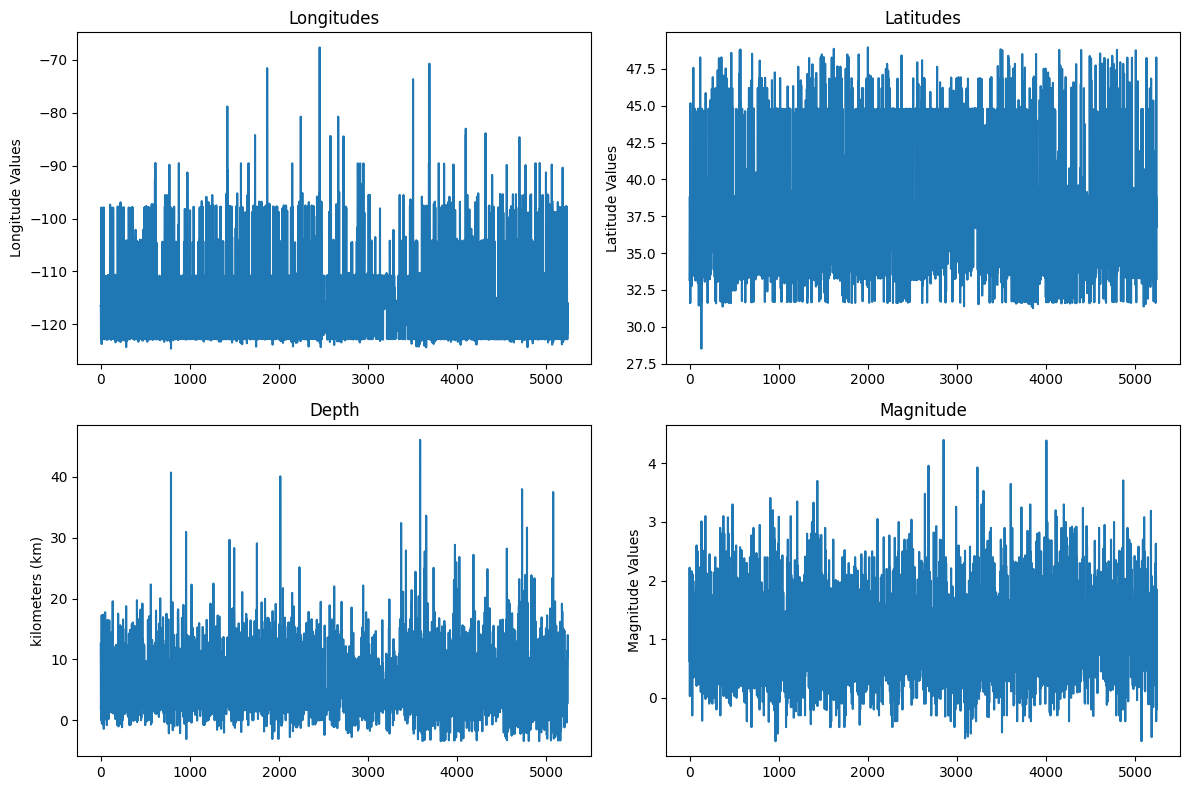

In [8]:
# Earthquake data Line plots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

sns.lineplot(data=earthquake_df['longitudes'], ax=axs[0, 0])
axs[0, 0].set_title("Longitudes")
axs[0, 0].set_ylabel("Longitude Values")

sns.lineplot(data=earthquake_df['latitudes'], ax=axs[0, 1])
axs[0, 1].set_title("Latitudes")
axs[0, 1].set_ylabel("Latitude Values")

sns.lineplot(data=earthquake_df['depth'], ax=axs[1, 0])
axs[1, 0].set_title("Depth")
axs[1, 0].set_ylabel("kilometers (km)")

sns.lineplot(data=earthquake_df['mag'], ax=axs[1, 1])
axs[1, 1].set_title("Magnitude")
axs[1, 1].set_ylabel("Magnitude Values")

plt.tight_layout()
plt.show()

The longitude plot reveals a clustering of earthquakes around -110° to -120°, likely indicating a seismic zone. The latitude plot shows a concentration of events between 30°N and 40°N, further confirming the association with a specific geographical region. The depth plot displays a range of earthquake depths, with a majority occurring at shallower levels. The magnitude plot exhibits a distribution of earthquakes across various magnitudes, with a concentration in the lower magnitude range.

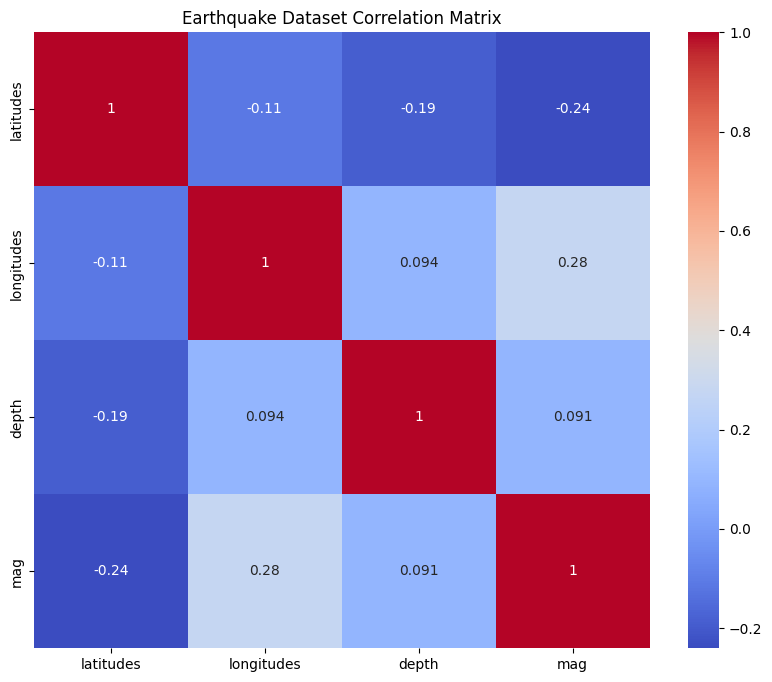

In [9]:
corr_matrix_eq = earthquake_df.drop('time', axis=1).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_eq, annot=True, cmap='coolwarm', square=True)
plt.title("Earthquake Dataset Correlation Matrix")
plt.show()

In [10]:
corr_matrix_eq

,latitudes,longitudes,depth,mag
latitudes,1.000000,-0.111713,-0.189988,-0.240327
longitudes,-0.111713,1.000000,0.093609,0.275629
depth,-0.189988,0.093609,1.000000,0.090865
mag,-0.240327,0.275629,0.090865,1.000000


The correlation matrix shows the weak relationships between the Earthquake dataset attributes. Latitudes and longitudes show a weak negative correlation (-0.11), indicating diverse geographical distributions. Depth and magnitude have a weak positive correlation (0.09), indicating deeper earthquakes tend to have larger magnitudes. Latitudes correlate negatively with depth (-0.19) and magnitude (-0.24), implying larger magnitude earthquakes occur at lower latitudes. Longitudes correlate positively with magnitude (0.28), indicating higher magnitude earthquakes occur at higher longitudes.

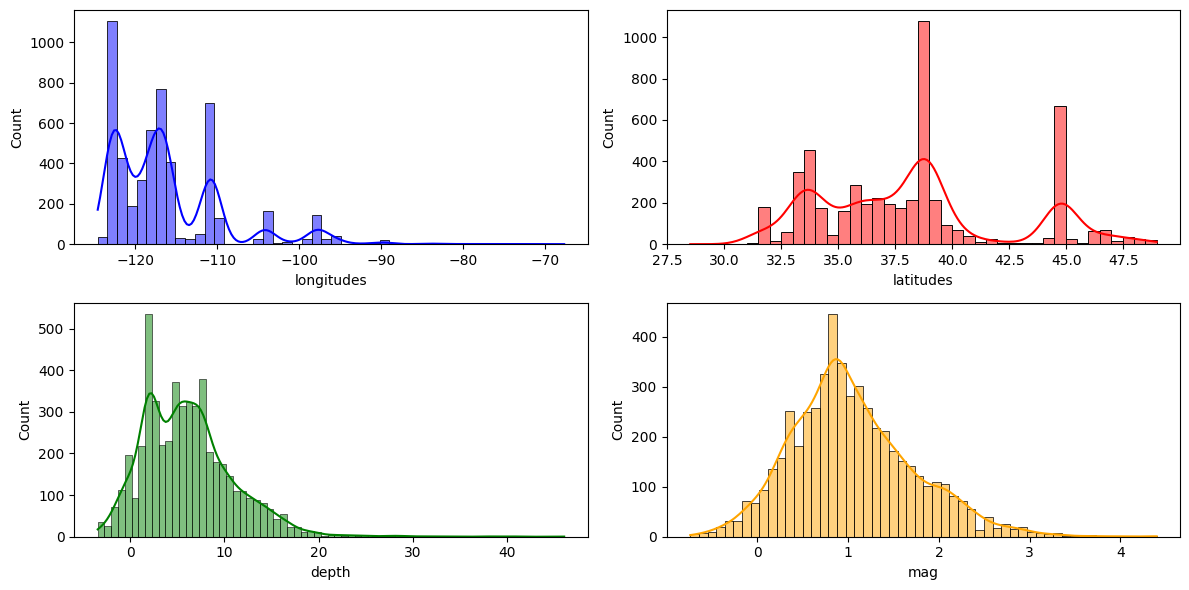

In [11]:
plt.figure(figsize=(12, 6))

sns.histplot(earthquake_df['longitudes'], kde=True, color='blue', ax=plt.subplot(2, 2, 1))
sns.histplot(earthquake_df['latitudes'], kde=True, color='red', ax=plt.subplot(2, 2, 2))
sns.histplot(earthquake_df['depth'], kde=True, color='green', ax=plt.subplot(2, 2, 3))
sns.histplot(earthquake_df['mag'], kde=True, color='orange', ax=plt.subplot(2, 2, 4))

plt.tight_layout()
plt.show()

Clusters of earthquakes are concentrated around longitudes -110 to -120, indicating a significant seismic zone in this region. Latitudes between 30 and 40 show a similar concentration, showing a multimodal distribution. The depth distribution is right-skewed, with a majority of earthquakes occurring at shallower depths. Also,the magnitude histogram is also right-skewed and shows a unimodal distribution, indicating that most earthquakes are of lower magnitude, with a few larger events.

### Houston Weather Dataset EDA

In [12]:
## Houston Weather Dataset EDA
print("Houston Weather Dataset Shape:", hwd_df.shape)
print("Houston Weather Dataset Columns:", hwd_df.columns)



Houston Weather Dataset Shape: (365, 9)
Houston Weather Dataset Columns: Index(['date', 'min_temp', 'max_temp', 'rainfall', 'wind_speed', 'pressure',
       'humidity', 'sunshine', 'Class'],
      dtype='object')


In [13]:
hwd_df.head()

,date,min_temp,max_temp,rainfall,wind_speed,pressure,humidity,sunshine,Class
0,1/1/2021,41,55,0.0,8,29.95,51,6,M
1,1/2/2021,41,59,0.0,7,30.09,42,0,M
2,1/3/2021,43,68,0.0,13,30.01,37,0,L
3,1/4/2021,49,75,0.0,3,29.99,43,0,M
4,1/5/2021,51,69,0.0,13,30.04,38,0,L


In [14]:
# Summary statistics
print("Houston Weather Dataset Summary:\n", hwd_df.describe())

# Data types
print("Houston Weather Dataset Data Types:\n", hwd_df.dtypes)





Houston Weather Dataset Summary:
          min_temp    max_temp    rainfall  wind_speed    pressure    humidity  \
count  365.000000  365.000000  365.000000  365.000000  365.000000  365.000000   
mean    64.139726   80.854795    0.261096   11.630137   29.935041   53.542466   
std     15.324142   12.421103    0.746692    5.407836    0.148247   17.020398   
min      0.000000   27.000000    0.000000    0.000000   29.560000   17.000000   
25%     54.000000   74.000000    0.000000    8.000000   29.840000   43.000000   
50%     68.000000   83.000000    0.000000   12.000000   29.920000   53.000000   
75%     76.000000   90.000000    0.000000   15.000000   30.020000   65.000000   
max     83.000000   98.000000    4.900000   29.000000   30.400000   91.000000   

         sunshine  
count  365.000000  
mean     4.345205  
std      3.152926  
min      0.000000  
25%      2.000000  
50%      4.000000  
75%      6.000000  
max     15.000000  
Houston Weather Dataset Data Types:
 date           obje

In [15]:
# Missing values
print("Houston Weather Dataset Missing Values:\n", hwd_df.isnull().sum())

Houston Weather Dataset Missing Values:
 date          0
min_temp      0
max_temp      0
rainfall      0
wind_speed    0
pressure      0
humidity      0
sunshine      0
Class         0
dtype: int64


No missing values in the houston weather dataset.

In [16]:
print(hwd_df.head())

       date  min_temp  max_temp  rainfall  wind_speed  pressure  humidity  \
0  1/1/2021        41        55       0.0           8     29.95        51   
1  1/2/2021        41        59       0.0           7     30.09        42   
2  1/3/2021        43        68       0.0          13     30.01        37   
3  1/4/2021        49        75       0.0           3     29.99        43   
4  1/5/2021        51        69       0.0          13     30.04        38   

   sunshine Class  
0         6     M  
1         0     M  
2         0     L  
3         0     M  
4         0     L  


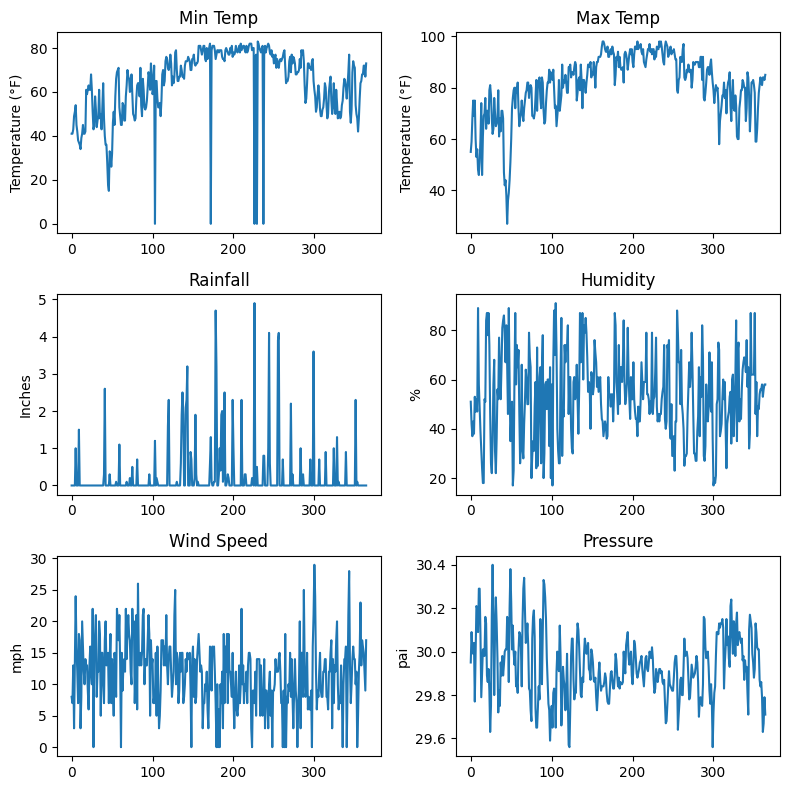

In [17]:
# Houston weather dataset Line plots
fig, axs = plt.subplots(3, 2, figsize=(8, 8))

sns.lineplot(data=hwd_df['min_temp'], ax=axs[0, 0])
axs[0, 0].set_title("Min Temp")
axs[0, 0].set_ylabel("Temperature (°F)")

sns.lineplot(data=hwd_df['max_temp'], ax=axs[0, 1])
axs[0, 1].set_title("Max Temp")
axs[0, 1].set_ylabel("Temperature (°F)")

sns.lineplot(data=hwd_df['rainfall'], ax=axs[1, 0])
axs[1, 0].set_title("Rainfall")
axs[1, 0].set_ylabel("Inches")

sns.lineplot(data=hwd_df['humidity'], ax=axs[1, 1])
axs[1, 1].set_title("Humidity")
axs[1, 1].set_ylabel("%")

sns.lineplot(data=hwd_df['wind_speed'], ax=axs[2, 0])
axs[2, 0].set_title("Wind Speed")
axs[2, 0].set_ylabel("mph")

sns.lineplot(data=hwd_df['pressure'], ax=axs[2, 1])
axs[2, 1].set_title("Pressure")
axs[2, 1].set_ylabel("pai")

plt.tight_layout()
plt.show()

The "Min Temp" and "Max Temp" plots exhibit seasonal patterns, with temperature values oscillating between lows during winter months and highs during summer. The "Rainfall" plot shows a more scattered pattern with spikes representing rainfall events, concentrated in certain seasons. The "Humidity" plot reveals a fluctuating trend, influenced by seasonal changes and weather patterns. The "Wind Speed" plot displays a more consistent pattern with occasional peaks indicating periods of higher wind activity. Lastly, the "Pressure" plot showcases a relatively stable trend with minor fluctuations, suggesting consistent atmospheric pressure conditions throughout the year.

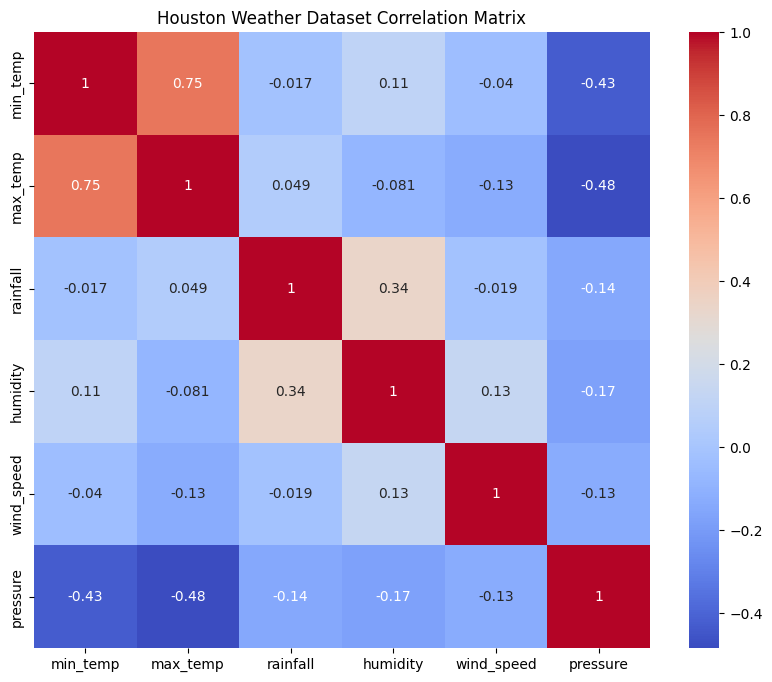

In [18]:
# Correlation matrix
corr_matrix = hwd_df[['min_temp', 'max_temp', 'rainfall', 'humidity', 'wind_speed', 'pressure']].corr()  #sunshine column excluded
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)
plt.title("Houston Weather Dataset Correlation Matrix")
plt.show()

Firstly, a strong positive correlation (0.75) exists between minimum and maximum temperatures, indicating that days with lower minimum temperatures tend to have lower maximum temperatures as well. Secondly, rainfall shows a moderate positive correlation with both minimum (0.11) and maximum temperatures (0.049), suggesting that higher temperatures might be associated with increased rainfall. Thirdly, humidity has a weak negative correlation with minimum (-0.017) and maximum temperatures (-0.081), implying that higher humidity might be associated with slightly lower temperatures. Lastly, wind speed shows a weak negative correlation with rainfall (-0.019), indicating that windy days might be less likely to experience rainfall. 

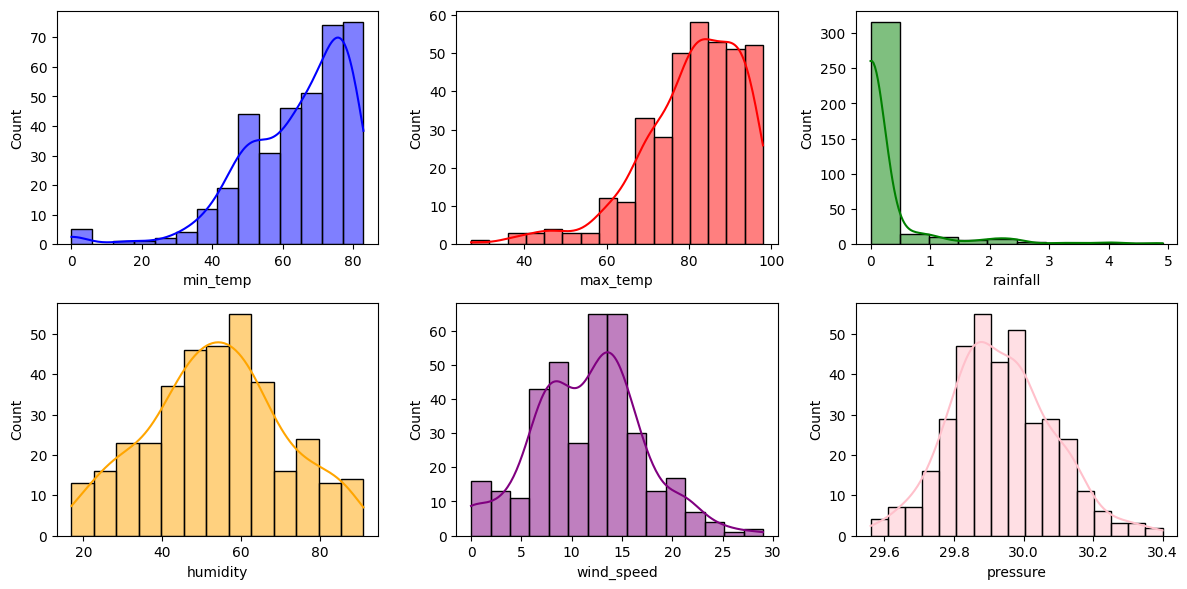

In [19]:
# Houston Weather Data Distribution plots
plt.figure(figsize=(12, 6))
sns.histplot(hwd_df['min_temp'], kde=True, color='blue', ax=plt.subplot(2, 3, 1))
sns.histplot(hwd_df['max_temp'], kde=True, color='red', ax=plt.subplot(2, 3, 2))
sns.histplot(hwd_df['rainfall'], kde=True, color='green', ax=plt.subplot(2, 3, 3))
sns.histplot(hwd_df['humidity'], kde=True, color='orange', ax=plt.subplot(2, 3, 4))
sns.histplot(hwd_df['wind_speed'], kde=True, color='purple', ax=plt.subplot(2, 3, 5))
sns.histplot(hwd_df['pressure'], kde=True, color='pink', ax=plt.subplot(2, 3, 6))
plt.tight_layout()
plt.show()

The "min_temp" and "max_temp" plots exhibit left-skewed distributions, indicating that there are more days with low and high temperatures. The "rainfall" plot is right-skewed, showing that most days have little to no rainfall. The "humidity" plot shows a normal distribution, with a peak around 50. The "wind_speed" plot shows a multimodal distribution, with a majority of days having lower wind speeds. Finally, the "pressure" plot also shows a normal distribution, with a peak around 55 pai. 

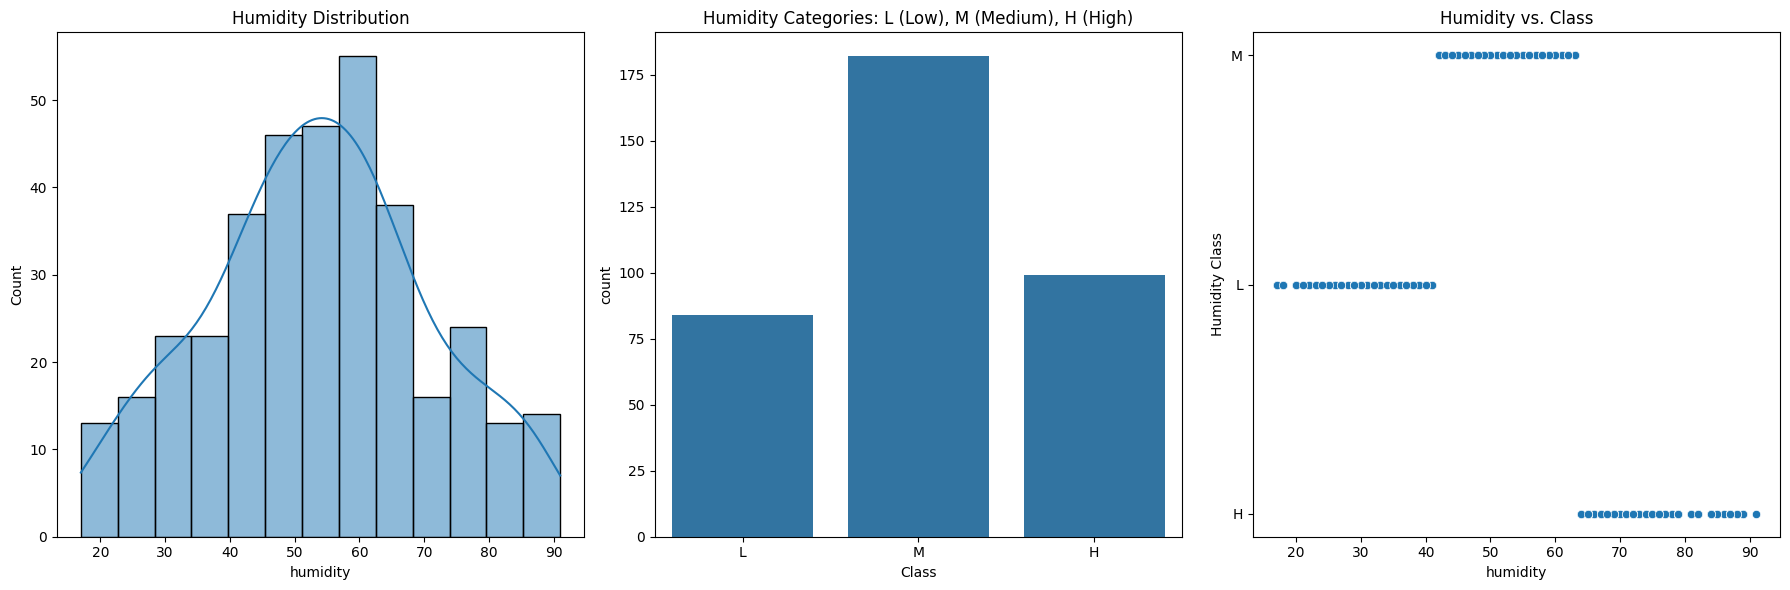

In [20]:
# Humidity Attribute
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Histogram with kde
sns.histplot(hwd_df['humidity'], kde=True, ax=axs[0])
axs[0].set_title("Humidity Distribution")

# Countplot with sorted categories
sns.countplot(x='Class', data=hwd_df, order=['L', 'M', 'H'], ax=axs[1])
axs[1].set_title("Humidity Categories: L (Low), M (Medium), H (High)")

# Scatterplot with categorical y-axis
sns.scatterplot(x='humidity', y='Class', data=hwd_df, ax=axs[2])
axs[2].set_title("Humidity vs. Class")
axs[2].set_ylabel('Humidity Class')
axs[2].set_yticks(['L', 'M', 'H'])

plt.tight_layout()
plt.show()

The second bar plot categorizes humidity into three classes: Low, Medium, and High. The distribution shows a predominance of Medium humidity values, followed by Low and High categories. The third scatter plot visualizes the relationship between humidity and a categorical class. The data points are concentrated around the Medium humidity range, with a few outliers extending towards higher humidity levels. 

In [21]:
# Count by Class
print(hwd_df['Class'].value_counts())

# Humidity summary stats by Class
print(hwd_df.groupby('Class')['humidity'].describe())

Class
M    182
H     99
L     84
Name: count, dtype: int64
       count       mean       std   min   25%   50%   75%   max
Class                                                          
H       99.0  74.656566  7.932318  64.0  67.0  74.0  81.5  91.0
L       84.0  30.630952  6.950392  17.0  26.0  31.0  37.0  41.0
M      182.0  52.631868  6.170835  42.0  47.0  52.0  58.0  63.0


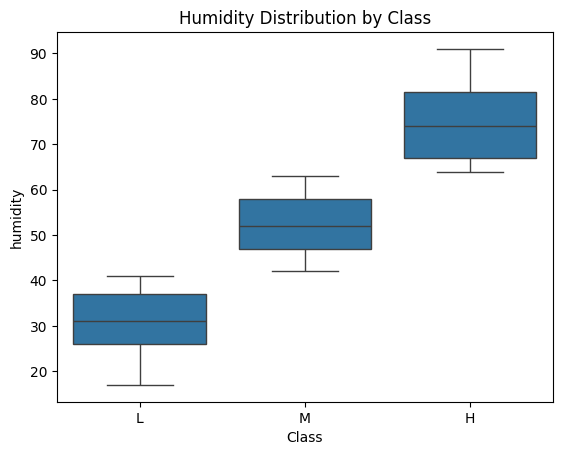

In [22]:
sns.boxplot(x='Class', y='humidity', data=hwd_df, order=['L', 'M', 'H'])
plt.title("Humidity Distribution by Class")
plt.show()

Based on the boxplot, Class H has the highest median humidity level at 74.0, with a range from 64.0 to 91.0, indicating consistently higher humidity levels. Class M exhibits the widest range of humidity values, from 42.0 to 63.0, with a median of 52.0, indicating greater variability. Class L has the lowest median humidity level at 31.0, with a range from 17.0 to 41.0, indicating more consistent and lower humidity levels. The count values show that Class M has the highest number of samples (182), followed by Class H (99) and Class L (84), which may contribute to the observed variability in Class M.

## Task 1

In [4]:
def purity(a, b, outliers=False):
    """
    Computes the purity of a clustering result.
    
    Args:
        a (array-like): Cluster assignments for objects in the dataset.
        b (array-like): True labels or ground-truth class assignments.
        outliers (bool): Whether to compute percentage of outliers.
                         Assumes cluster '0' represents outliers if present.
    
    Returns:
        float or tuple: Purity score, and if outliers=True, a tuple with purity and percentage of outliers.
    """
    a = np.array(a)
    b = np.array(b)
    
    if outliers:
        outlier_mask = (a == 0)
        num_outliers = np.sum(outlier_mask)
        total_examples = len(a)
        percentage_outliers = num_outliers / total_examples
        
        a = a[~outlier_mask]
        b = b[~outlier_mask]

        # Adjust cluster assignments to start from 0
        a = a - 1
    else:
        percentage_outliers = 0
    
    contingency_matrix = confusion_matrix(b, a)
    purity_score = np.sum(np.amax(contingency_matrix, axis=0)) / len(b)
    
    if outliers:
        return purity_score, percentage_outliers
    else:
        return purity_score

## Task 2

In [5]:
def asse(a, b):
    """
    Computes the Average Sum of Squared Errors (ASSE) for a clustering result.

    Args:
        a (array-like): Cluster assignments for objects in the dataset.
        b (array-like): Values of the numerical attribute.

    Returns:
        float: ASSE score for the clustering result.
    """
    a = np.array(a)
    b = np.array(b)

    # Exclude outliers (assuming cluster 0 represents outliers)
    non_outlier_mask = (a != 0)
    a = a[non_outlier_mask]
    b = b[non_outlier_mask]

    total_squared_error = 0
    total_examples = 0

    for cluster in np.unique(a):
        cluster_mask = (a == cluster)
        cluster_values = b[cluster_mask]

        cluster_mean = np.mean(cluster_values)
        squared_errors = np.sum((cluster_values - cluster_mean) ** 2)

        total_squared_error += squared_errors
        total_examples += len(cluster_values)

    asse_score = total_squared_error / total_examples
    return asse_score

## Task 3

In [ ]:
def visualize_eq_clusters_with_boundaries(df, lon_col, lat_col, cluster_col, title, purity_score=None, asse_score=None):
    """
    Visualizes earthquake clusters on the map with cluster boundaries.

    Args:
        df (DataFrame): DataFrame containing longitude, latitude, and cluster assignments.
        lon_col (str): Column name for longitude values.
        lat_col (str): Column name for latitude values.
        cluster_col (str): Column name for cluster assignments.
        title (str): Title for the visualization.
        purity_score (float): Purity score for the clustering result. Defaults to None.
        asse_score (float): ASSE score for the clustering result. Defaults to None.
    """
    
    usa_map = gpd.read_file('contiguousUSA.shp')
    usa_map = usa_map.to_crs("epsg:4326")

    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[lon_col], df[lat_col]), crs="EPSG:4326")

    cluster_boundaries = []
    for cluster_id, group in gdf.groupby(cluster_col):
        points = MultiPoint([point for point in group.geometry])
        if points.geoms:  # Check if MultiPoint is not empty
            boundary = points.convex_hull
            cluster_boundaries.append({"Cluster": cluster_id, "geometry": boundary})

    boundary_gdf = gpd.GeoDataFrame(cluster_boundaries, crs="EPSG:4326")

    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    usa_map.plot(ax=ax, color="#fbe5af", edgecolor="black", alpha=0.7)
    boundary_gdf.boundary.plot(ax=ax, color="black", linestyle="--", linewidth=1.5, label="Cluster Boundaries")

    #Create custom legend
    labels = np.unique(df[cluster_col])
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=f"Cluster {label}", 
                                markerfacecolor=plt.cm.tab20(label / len(labels)), markersize=10) 
                      for label in labels]
    
    gdf.plot(column=cluster_col, cmap="tab20", ax=ax, alpha=0.8, markersize=100, edgecolor="black", legend=False)
    
    ax.legend(handles=legend_handles, loc='lower right', title="Clusters")

    ax.set_title(f"{title}\nPurity: {purity_score:.3f}, ASSE: {asse_score:.3f}" if purity_score and asse_score else title, fontsize=16)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.grid(False)
    plt.show()

## Task 4

In [7]:
# Normalize attributes
earthquake_normalized = (earthquake_df[["longitudes", "latitudes"]] - 
                         earthquake_df[["longitudes", "latitudes"]].min()) / (
                        earthquake_df[["longitudes", "latitudes"]].max() - 
                        earthquake_df[["longitudes", "latitudes"]].min())



In [8]:
print(earthquake_normalized.head(5))


   longitudes  latitudes
0    0.143906   0.228532
1    0.144842   0.265322
2    0.032685   0.503299
3    0.030837   0.504611
4    0.032481   0.502737


K=5
ASSE (magnitude): 0.3813776962758511
ASSE (depth): 20.691472437195834

K=9
ASSE (magnitude): 0.37083385071279673
ASSE (depth): 20.370925516184037

K=13
ASSE (magnitude): 0.3499373517169245
ASSE (depth): 17.179741449946224

K=17
ASSE (magnitude): 0.32065786474970576
ASSE (depth): 17.786659332214988



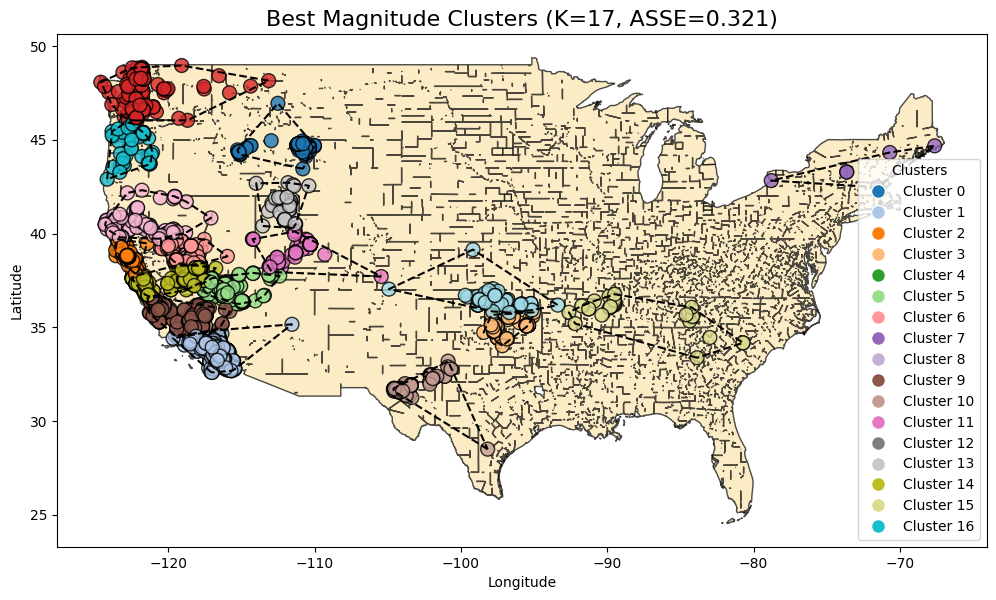

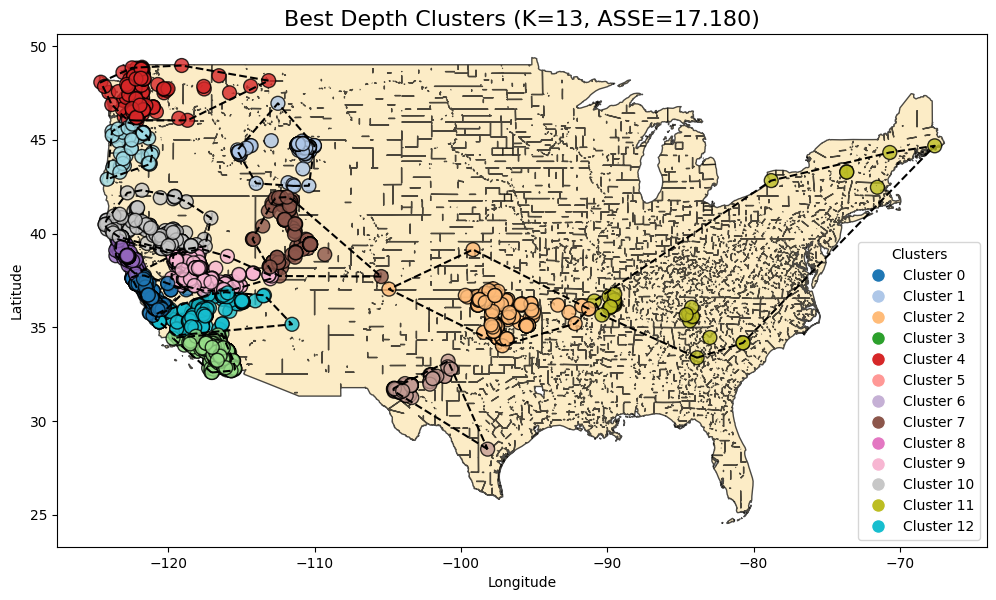

In [9]:
# Run K-means for k=5, 9, 13, 17
k_values = [5, 9, 13, 17]
kmeans_results = []
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(earthquake_normalized)
    kmeans_results.append(kmeans.labels_)


# Calculate ASSE for magnitude and depth attributes
asse_values_k = []
for i, k in enumerate(k_values):
    asse_magnitude = asse(kmeans_results[i], earthquake_df['mag'])
    asse_depth = asse(kmeans_results[i], earthquake_df['depth'])
    asse_values_k.append((asse_magnitude, asse_depth))


# Results
for k, asse_result_k in zip(k_values, asse_values_k):
    print(f"K={k}")
    print(f"ASSE (magnitude): {asse_result_k[0]}")
    print(f"ASSE (depth): {asse_result_k[1]}\n")


# Visualize clusters for best magnitude and depth
best_magnitude_k = k_values[np.argmin([asse[0] for asse in asse_values_k])]
best_depth_k = k_values[np.argmin([asse[1] for asse in asse_values_k])]


visualize_eq_clusters_with_boundaries(earthquake_df.assign(cluster=lambda x: kmeans_results[k_values.index(best_magnitude_k)]), 
                      "longitudes", "latitudes", "cluster", 
                      title=f"Best Magnitude Clusters (K={best_magnitude_k}, ASSE={asse_values_k[np.argmin([asse[0] for asse in asse_values_k])][0]:.3f})")


visualize_eq_clusters_with_boundaries(earthquake_df.assign(cluster=lambda x: kmeans_results[k_values.index(best_depth_k)]), 
                      "longitudes", "latitudes", "cluster", 
                      title=f"Best Depth Clusters (K={best_depth_k}, ASSE={asse_values_k[np.argmin([asse[1] for asse in asse_values_k])][1]:.3f})")




In [11]:
asse_values_k

[(0.3813776962758511, 20.691472437195834),
 (0.37083385071279673, 20.370925516184037),
 (0.3499373517169245, 17.179741449946224),
 (0.32065786474970576, 17.786659332214988)]

In [12]:
asse_result_k

(0.32065786474970576, 17.786659332214988)

In [13]:
best_magnitude_k 


17

In [14]:
best_depth_k

13

After running K-means clustering on the Earthquake dataset with k values of 5, 9, 13, and 17, some interesting patterns emerged. For k=5, the ASSE (average sum of squared errors) for magnitude was 0.381 and for depth was 20.691. As k increased, the ASSE for magnitude kept dropping, hitting 0.321 at k=17, meaning the clusters got better at grouping similar magnitudes together. But for depth, the sweet spot was k=13 with an ASSE of 17.180, showing the best clustering for depth. Geographically, these clusters highlighted distinct regions where earthquakes of varying depths and magnitudes occurred, giving a clear picture of how these characteristics are spread out. As the best magnitude occurred at K=17, clusters were better grouped together unlike the best depth clusters.

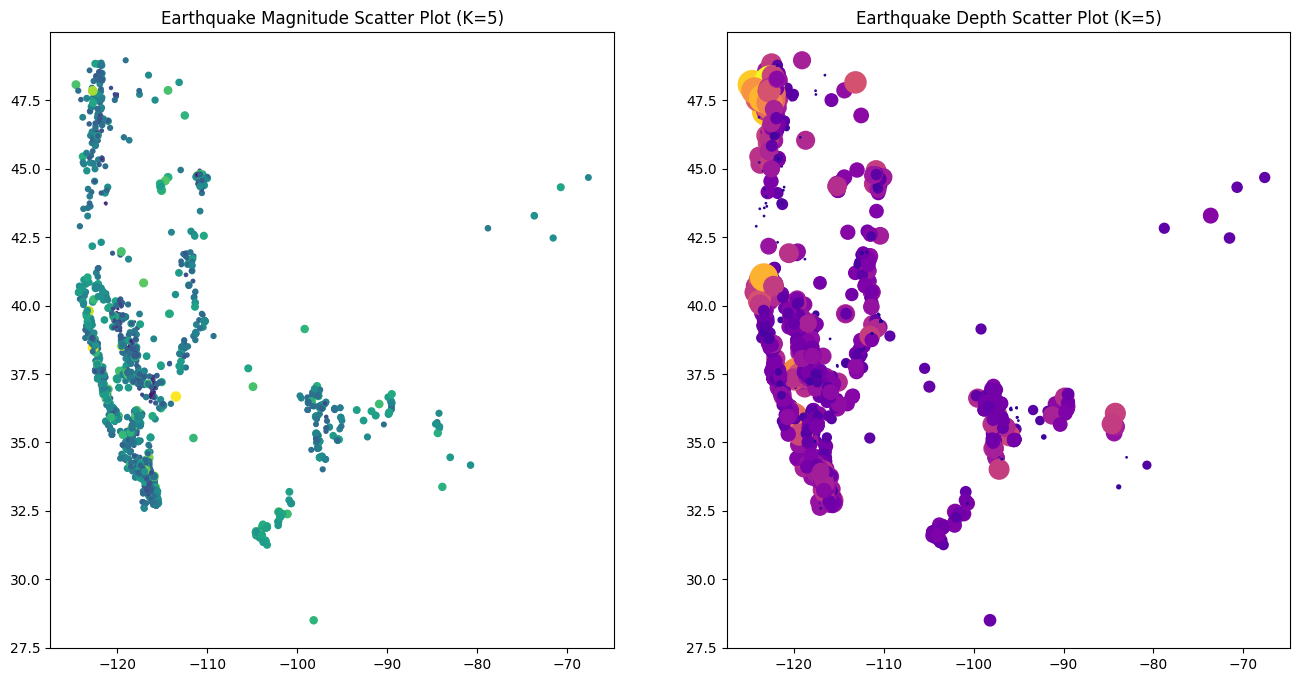

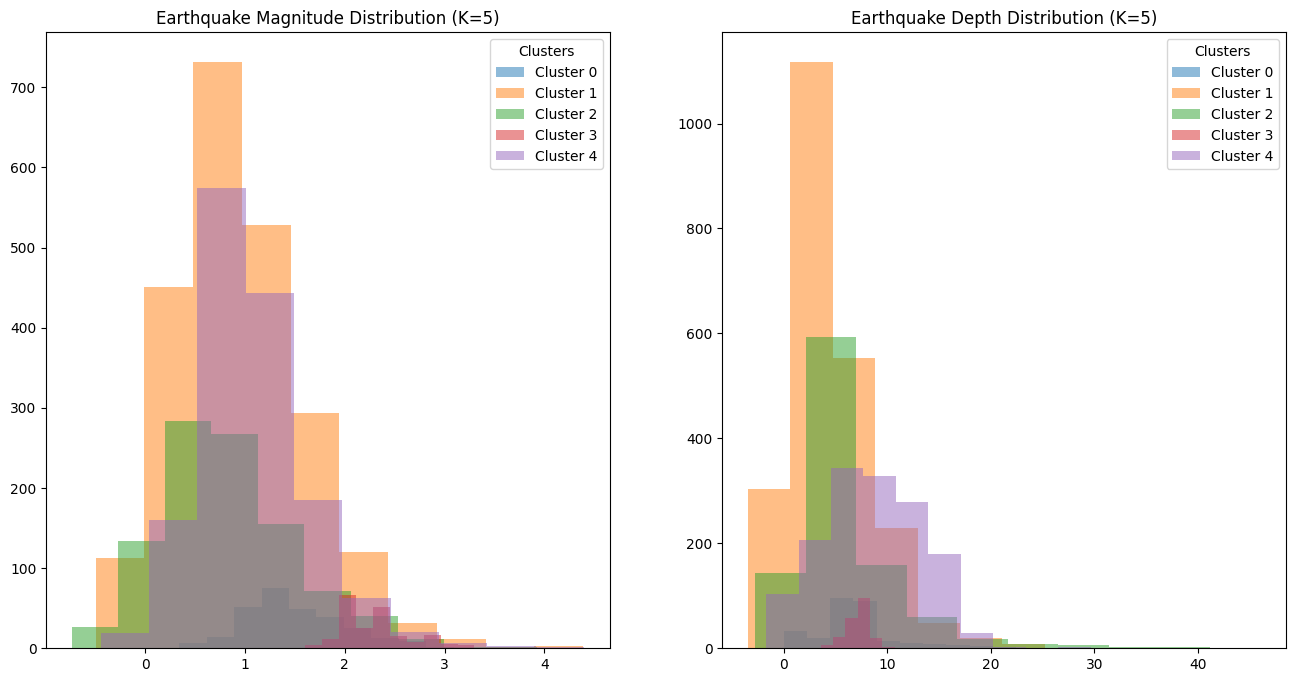

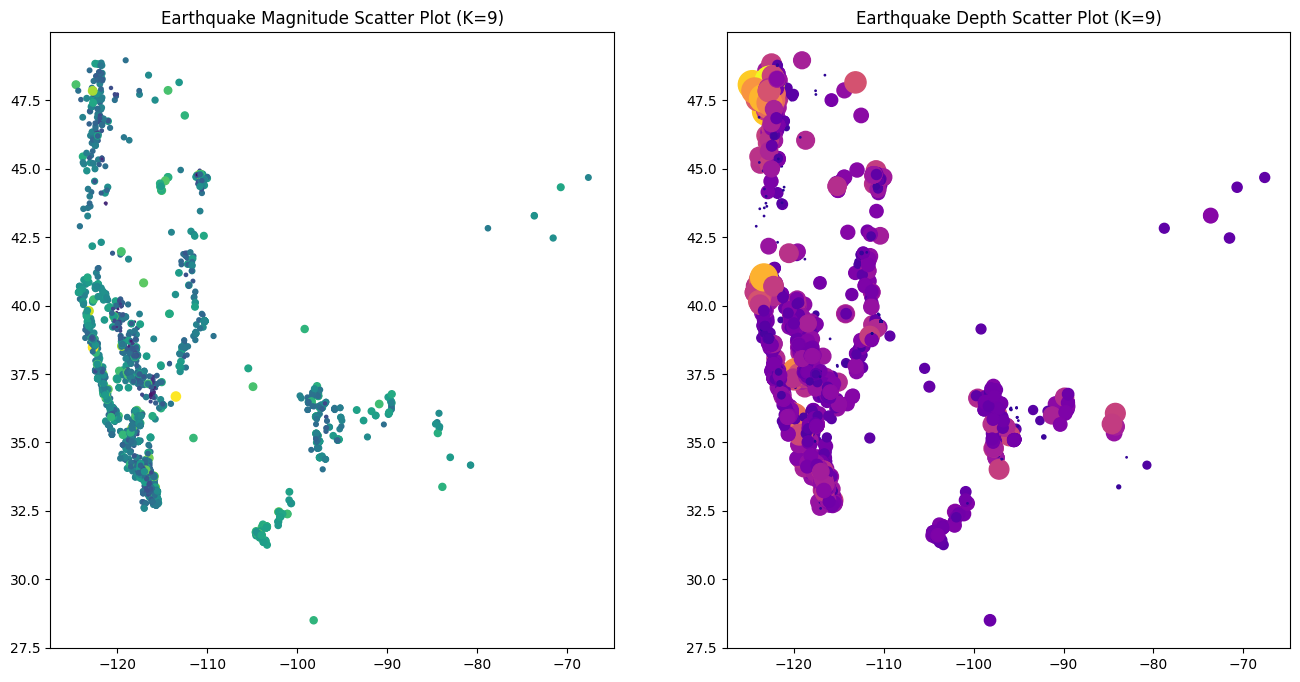

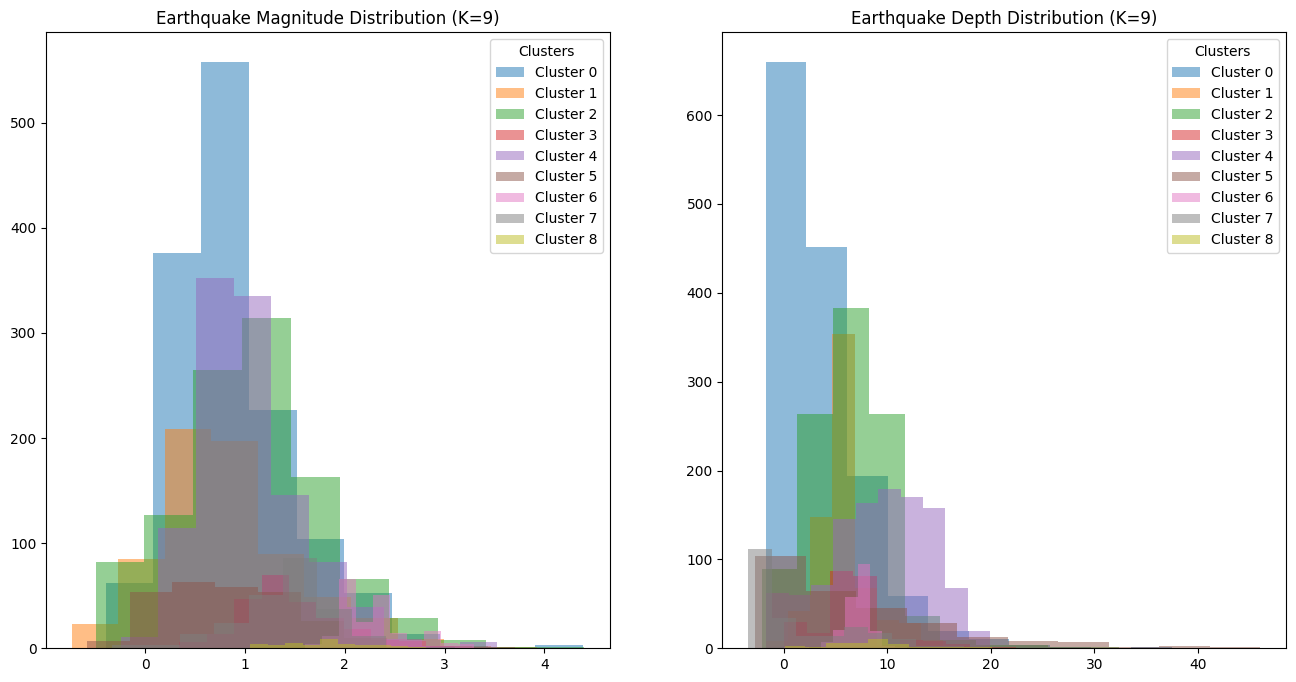

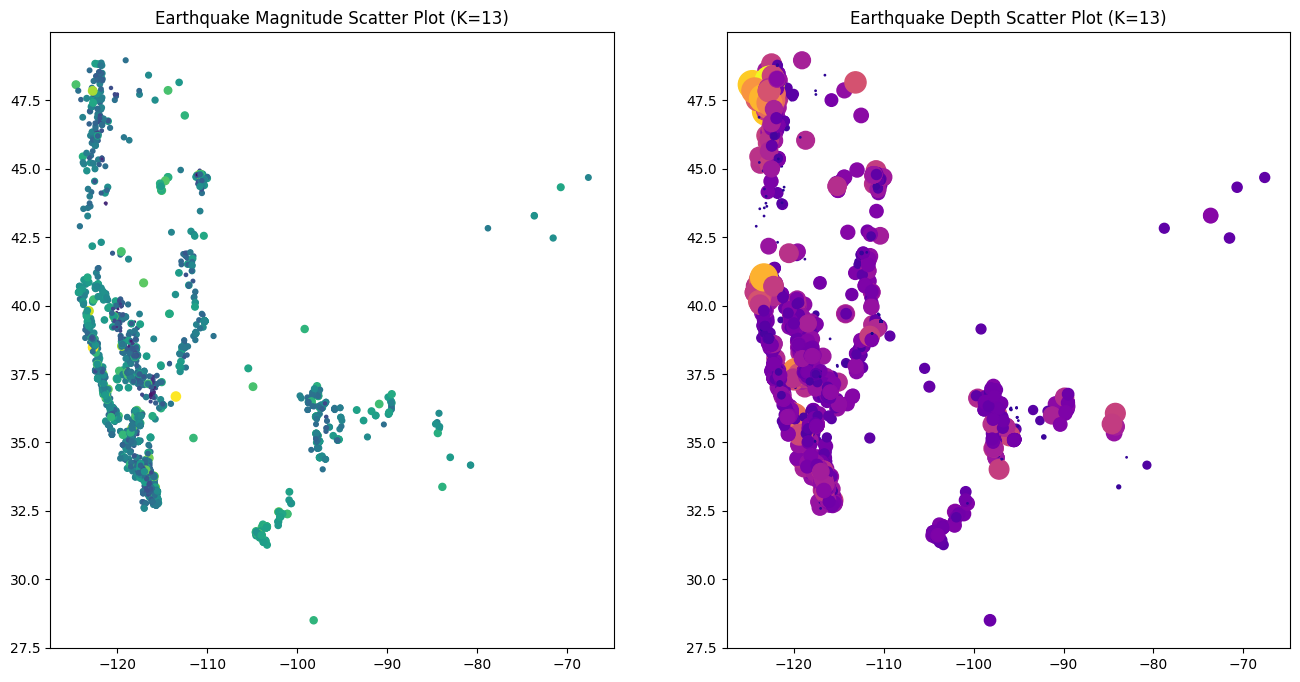

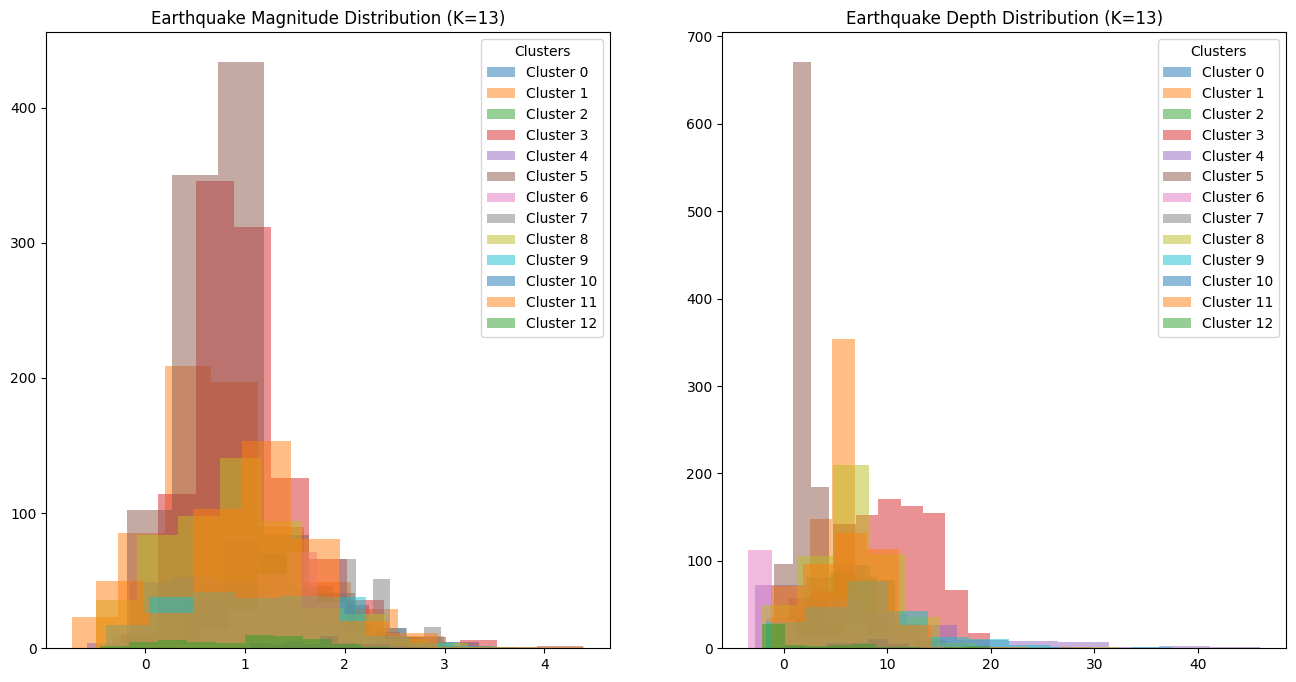

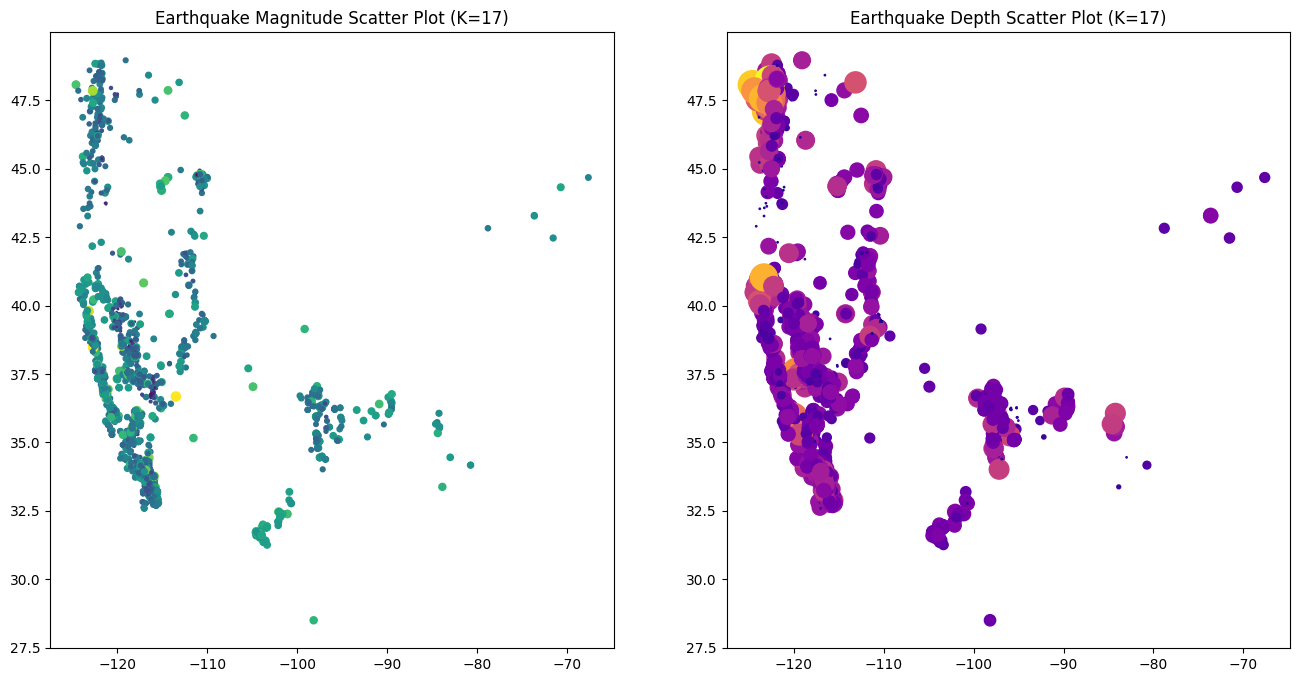

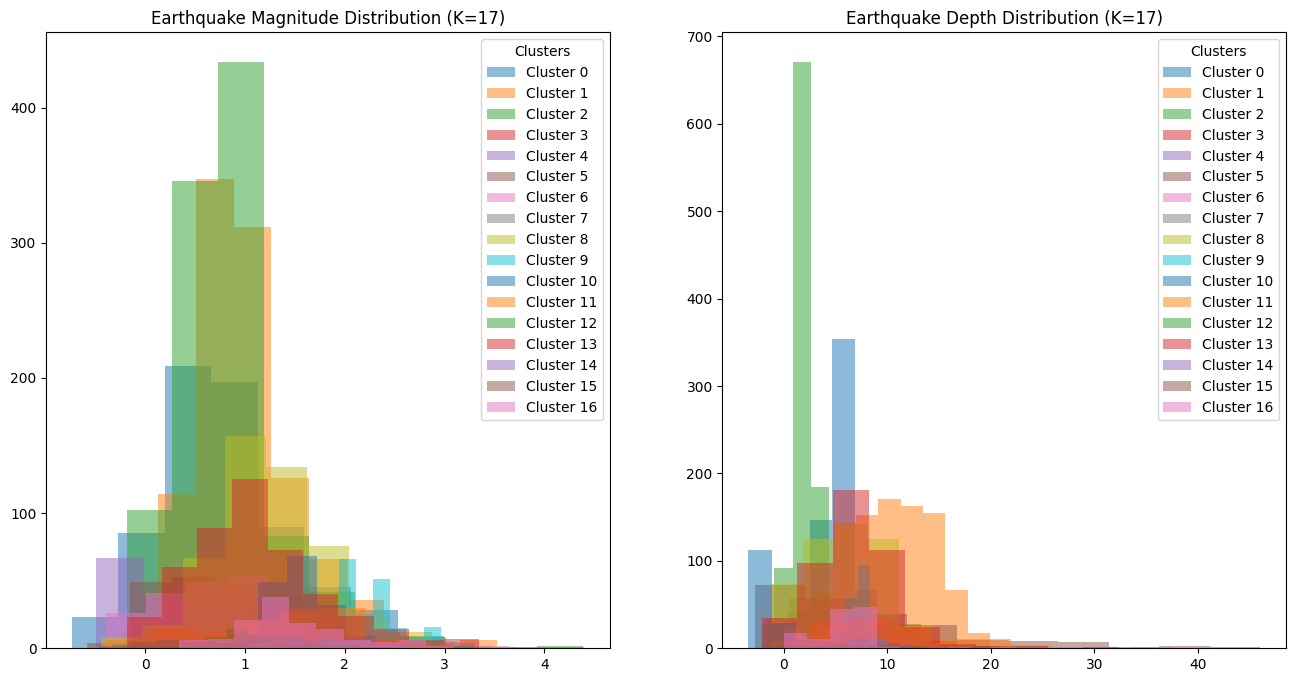

In [17]:
# Scatter and Box plots
for k, kmeans_result in zip(k_values, kmeans_results):
    df_clustered = earthquake_df.assign(cluster=lambda x: kmeans_result)
    
    # Scatter plot with varying marker sizes/color intensity for magnitude/depth
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax[0].scatter(df_clustered["longitudes"], df_clustered["latitudes"], c=df_clustered['mag'], cmap='viridis', s=np.maximum(df_clustered['mag']*10, 1))
    ax[0].set_title(f"Earthquake Magnitude Scatter Plot (K={k})")
    ax[1].scatter(df_clustered["longitudes"], df_clustered["latitudes"], c=df_clustered['depth'], cmap='plasma', s=np.maximum(df_clustered['depth']*10, 1))
    ax[1].set_title(f"Earthquake Depth Scatter Plot (K={k})")
    
    # Histograms/box plots for magnitude/depth distribution within clusters
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    labels = np.unique(df_clustered['cluster'])
    for label in labels:
        cluster_df = df_clustered[df_clustered['cluster'] == label]
        ax[0].hist(cluster_df['mag'], alpha=0.5, label=f"Cluster {label}")
        ax[1].hist(cluster_df['depth'], alpha=0.5, label=f"Cluster {label}")
    ax[0].set_title(f"Earthquake Magnitude Distribution (K={k})")
    ax[1].set_title(f"Earthquake Depth Distribution (K={k})")
    ax[0].legend(title="Clusters")
    ax[1].legend(title="Clusters")
    
    plt.show()

For k = 5, 9, 13 and 17, the Magnitude Scatter Plots shows that the cluster of earthquakes are all concentrated around the 35-40 degree latitude range and -130 to -110 longitude range. 

For k = 5, 9, 13 and 17, the Depth Scatter Plot shows a clear vertical trend, with most earthquakes occurring at depths between 30 and 40 kilometers. This indicates a consistent depth range for seismic activity in this region.

For k = 5, the Magnitude Histogram shows that Cluster 1 has the highest number of earthquakes with magnitudes less than 1, while Cluster 3 has the highest number of earthquakes with magnitudes greater than 1. It is a normal distribution.

For k = 5, the Depth Histogram reveals that Cluster 1 has the highest number of earthquakes with depths less than 10 km, while Cluster 2 has the highest number of earthquakes with depths greater than 10 km. The distribution is right-skewed.

For k = 9,the Magnitude Histogram shows that Cluster 0 has the highest number of earthquakes with magnitudes less than 1, while Cluster 2 has the highest number of earthquakes with magnitudes greater than 1. This is a multimodal distribtion.

For k = 9, the Depth Histogram reveals that Cluster 0 has the highest number of earthquakes with depths less than 10 km, while Cluster 2 has the highest number of earthquakes with depths greater than 10 km. The distribution is right-skewed.

For k = 13,the Magnitude Histogram shows that Cluster 5 has the highest number of earthquakes with magnitudes less than 1, while Cluster 3 has the highest number of earthquakes with magnitudes greater than 1. This is a multimodal distribtion.

For k = 13, the Depth Histogram reveals that Cluster 5 has the highest number of earthquakes with depths less than 10 km, while Cluster 6 has the highest number of earthquakes with depths greater than 10 km. This is a multimodal distribtion.

For k = 17,the Magnitude Histogram shows that Cluster 2 has the highest number of earthquakes with magnitudes less than 1, while Cluster 1 has the highest number of earthquakes with magnitudes greater than 1. This is a normal distribtion.

For k = 17, the Depth Histogram reveals that Cluster 2 has the highest number of earthquakes with depths less than 10 km, while Cluster 1 has the highest number of earthquakes with depths greater than 10 km. This is a multimodal distribtion.

## Task 5

Cluster 0, 1 and 2 represents the Low, Midium and High classes respectively.

Clustering iteration with the Lowest SSE: 4
Labels: [0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 0 0 0 1 0 0 0 0 1 1 1
 0 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 1 0 0 0 0 1 1 0 2 1 1
 1 2 0 0 0 0 1 2 1 2 2 1 0 0 1 1 0 0 0 0 2 1 1 2 1 2 1 2 1 1 1 1 1 0 0 2 0
 1 1 2 2 2 1 1 1 1 1 2 1 2 2 2 2 1 1 2 2 1 0 2 1 1 1 1 1 2 1 1 1 1 1 2 2 2
 2 1 1 2 2 1 1 1 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 1 1 2 2 2 1 2
 1 1 2 1 1 2 2 2 2 1 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 1 2 2 2 2
 2 2 1 2 0 2 2 0 2 2 2 2 2 2 2 0 2 1 2 2 2 1 1 1 2 2 2 2 2 2 2 2 2 1 1 1 1
 2 1 2 2 2 2 2 2 2 2 2 1 1 1 1 2 2 2 2 2 2 2 2 1 2 2 2 1 1 0 0 0 1 2 2 2 1
 2 2 1 1 2 0 0 0 0 0 1 0 0 0 0 0 0 2 1 0 0 0 0 2 2 0 0 0 1 0 0 1 1 0 0 0 0
 0 0 0 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 1 2 1 1 2 2 2 1]
SSE: 46.034505090431914
Purity: 0.7056603773584905
Percentage outliers: 0.273972602739726


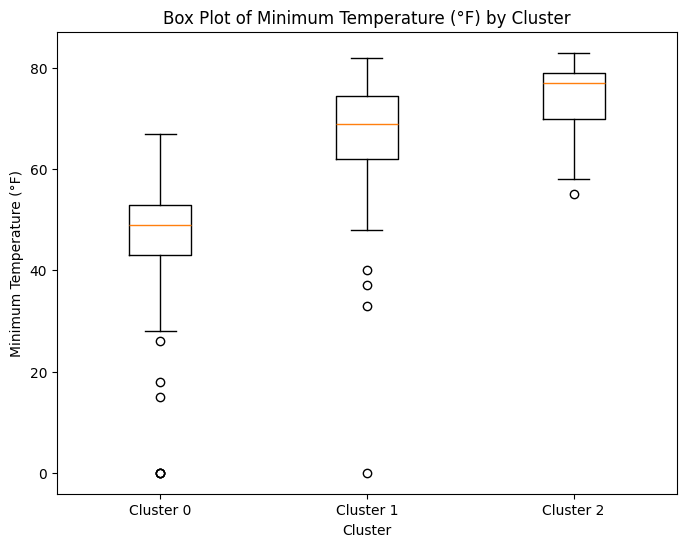

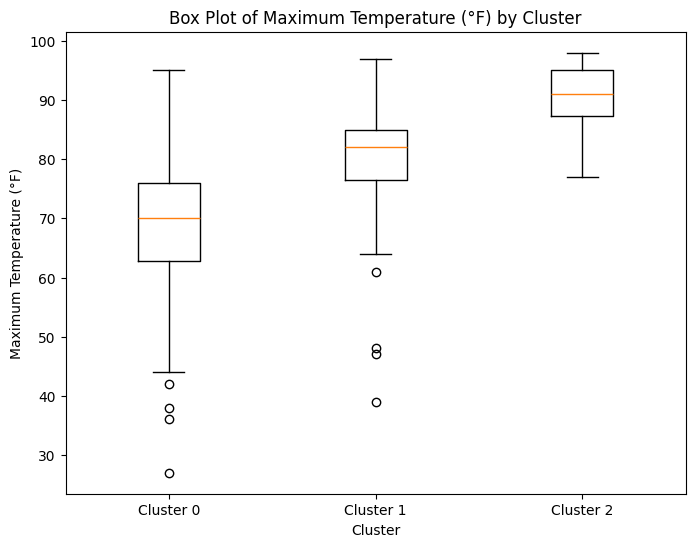

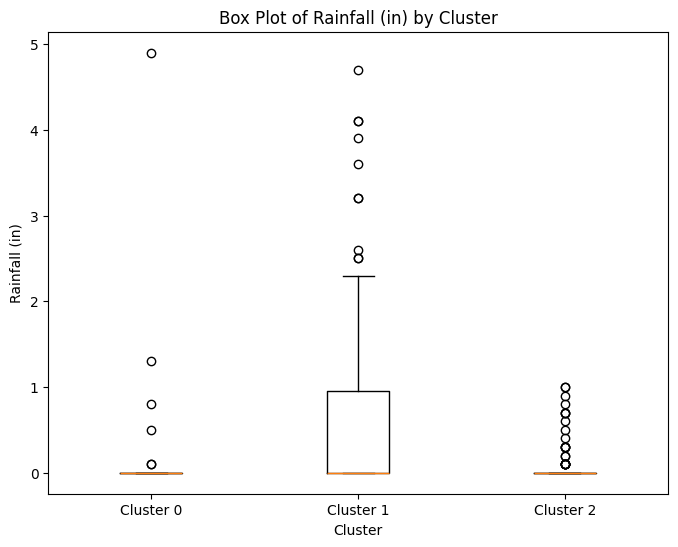

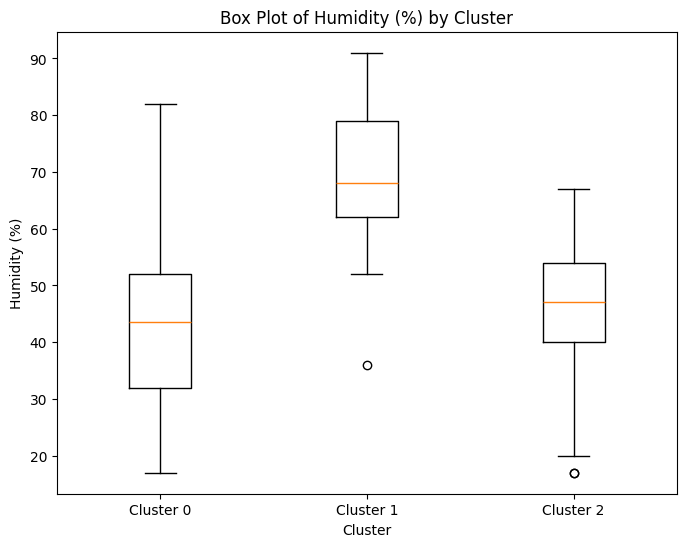

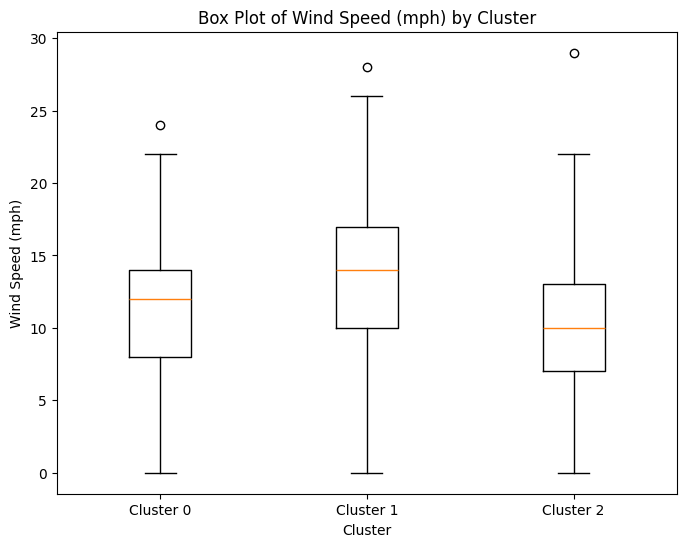

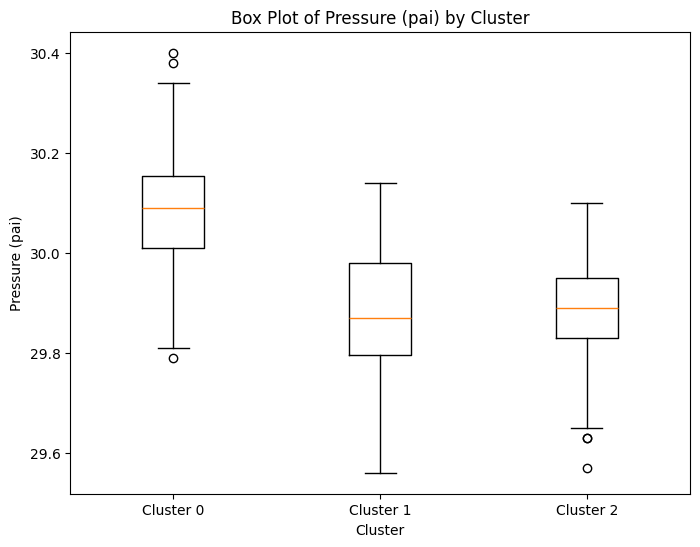

In [21]:
# Normalize attributes
hwd_normalized = (hwd_df[["min_temp", "max_temp", "rainfall", "humidity", "wind_speed", "pressure"]] - 
                  hwd_df[["min_temp", "max_temp", "rainfall", "humidity", "wind_speed", "pressure"]].min()) / (
                 hwd_df[["min_temp", "max_temp", "rainfall", "humidity", "wind_speed", "pressure"]].max() - 
                 hwd_df[["min_temp", "max_temp", "rainfall", "humidity", "wind_speed", "pressure"]].min())

# Run K-means 10 times
sse_values_k = []
kmeans_results = []
for _ in range(10):
    kmeans = KMeans(n_clusters=3)
    kmeans.fit(hwd_normalized)
    sse_values_k.append(kmeans.inertia_)
    kmeans_results.append(kmeans.labels_)


# Select clustering with lowest SSE
best_index_k = np.argmin(sse_values_k)
best_kmeans_labels = kmeans_results[best_index_k]


# Print the clustering with the lowest SSE
print("Clustering iteration with the Lowest SSE:", best_index_k)
print("Labels:", best_kmeans_labels)
print("SSE:", sse_values_k[best_index_k])


# Map string labels to numerical labels
label_mapping_k = {label: i for i, label in enumerate(hwd_df['Class'].unique())}
numerical_labels_k = hwd_df['Class'].map(label_mapping_k)


# Calculate purity with outliers consideration
kmeans_purity_result = purity(best_kmeans_labels, numerical_labels_k, outliers=True)
print("Purity:", kmeans_purity_result[0])
print("Percentage outliers:", kmeans_purity_result[1])


# Create box plots for attributes
attributes = {
    "min_temp": "Minimum Temperature (°F)",
    "max_temp": "Maximum Temperature (°F)",
    "rainfall": "Rainfall (in)",
    "humidity": "Humidity (%)",
    "wind_speed": "Wind Speed (mph)",
    "pressure": "Pressure (pai)"
}

for attribute, attribute_name in attributes.items():
    plt.figure(figsize=(8, 6))
    plt.boxplot([hwd_df[best_kmeans_labels == c][attribute] for c in range(3)], 
                labels=[f"Cluster {c}" for c in range(3)])
    plt.title(f"Box Plot of {attribute_name} by Cluster")
    plt.xlabel("Cluster")
    plt.ylabel(attribute_name)
    plt.show()

After running K-means clustering on the Houston Weather Dataset (HWD) with k=3, the purity score was 0.705, meaning about 70.6% of the data points were correctly clustered according to the ground truth labels, but with 27.4% outliers, indicating room for improvement. 

The box plots for attributes like min_temp, max_temp, rainfall, humidity, wind_speed, and pressure revealed distinct characteristics for each cluster. 

Cluster 2 had the highest max_temp (98.00°F) and min_temp (82.00°F), with rainfall (0.077 in). Cluster 2's rainfall box plot shows a median value of 0.068 in, with the lower quartile at 0.02 in and the upper quartile at 0.1 in, indicating a low amount of rainfall.

Cluster 1 showed high max_temp (80.11°F) and humidity (90.19%), with moderate wind_speed (27.95 mph), lowest pressure (29.55 pai) and rainfall (2.234 in). The max_temp box plot for Cluster 1 shows a median value of 80.11°F, with the lower quartile at 75°F and the upper quartile at 85°F, reflecting a wider range of temperatures. 

Cluster 0 had the lowest max_temp (45.44°F) and min_temp (28.33°F), with the lowest rainfall (0.068 in) with outliers ranging from 0-5in. These clusters highlight how different weather attributes contribute to the overall clustering, providing insights into the weather patterns in Houston. Cluster 0 had a median max_temp of 70.17°F, with lower and upper quartiles at 64°F and 76°F, respectively, and a few outliers beyond the range (20-44°F). 


In [22]:
# Calculate centroids_k and means
best_kmeans = KMeans(n_clusters=3)
best_kmeans.fit(hwd_normalized)
centroids_k = best_kmeans.cluster_centers_
print("\nCentroids_k:")
print(centroids_k)


print("\n---------------------------------------------------")
print("Means:")
cluster_means = [hwd_df[best_kmeans_labels == c][["min_temp", "max_temp", "rainfall", "humidity", "wind_speed", "pressure"]].mean() for c in range(3)]
for i, mean in enumerate(cluster_means):
    print(f"Cluster {i}:")
    print(mean)
    print()


print("---------------------------------------------------")


# Summarize cluster characteristics
print("\nCluster Summary:")
for i, mean in enumerate(cluster_means):
    print(f"Cluster {i}:")
    attributes_sorted = sorted(zip(mean.values, mean.index), reverse=True)
    top_attributes = attributes_sorted[:2]
    bottom_attributes = attributes_sorted[-2:]
    
    print("Highest values in:")
    for attribute in top_attributes:
        print(f"{attribute[1]} ({attribute[0]}),")
        
    print("\nLowest values in:")
    for attribute in bottom_attributes:
        print(f"{attribute[1]} ({attribute[0]}).")
        
    print()


print("---------------------------------------------------")


# Interpret purity
print("\nPurity Interpretation:")
print(f"Purity: {kmeans_purity_result[0]}")
print(f"Percentage outliers: {kmeans_purity_result[1]}")
if kmeans_purity_result[0] > 0.8:
    print("High purity indicates good clustering quality.")
else:
    print("Low purity indicates that there's room for improvement in clustering result.")


Centroids_k:
[[0.89045913 0.87552341 0.02140099 0.45807159 0.40745573 0.35855856]
 [0.58089501 0.59873527 0.00458142 0.31467181 0.37614356 0.63277454]
 [0.73655598 0.68550326 0.18342459 0.78856295 0.41631623 0.42218351]]

---------------------------------------------------
Means:
Cluster 0:
min_temp      46.1300
max_temp      68.1700
rainfall       0.0770
humidity      43.6100
wind_speed    11.1200
pressure      30.0889
dtype: float64

Cluster 1:
min_temp      67.016260
max_temp      80.105691
rainfall       0.634146
humidity      70.186992
wind_speed    13.951220
pressure      29.875610
dtype: float64

Cluster 2:
min_temp      74.330986
max_temp      90.436620
rainfall       0.067606
humidity      46.119718
wind_speed     9.978873
pressure      29.878169
dtype: float64

---------------------------------------------------

Cluster Summary:
Cluster 0:
Highest values in:
max_temp (68.17),
min_temp (46.13),

Lowest values in:
wind_speed (11.12).
rainfall (0.077).

Cluster 1:
Highest valu

Additionally, the centroids for the three clusters reveal distinct patterns across the six attributes, representing low, medium, and high classifications of weather conditions. 

Cluster 0's centroid values for min_temp, max_temp, rainfall, humidity, wind_speed and pressure were 0.890 °F, 0.876 °F, 0.021 in, 0.458, 0.407 mph and 0.359 pai respectively, which are higher weather conditions compared to the other clusters. 

Cluster 1's centroid values for min_temp, max_temp, rainfall, humidity, wind_speed and pressure were 0.581 °F, 0.599 °F, 0.005 in, 0.315, 0.376 mph and 0.633 pai respectively, which are lower weather conditions compared to the other clusters. 

Cluster 2's centroid values for min_temp, max_temp, rainfall, humidity, wind_speed and pressure were 0.737 °F, 0.686 °F, 0.183 in, 0.789, 0.416 mph and 0.422 pai respectively, which have the second highest weather conditions across board compared to the other clusters. 



## Task 6

EPS: 0.01, Min Samples: 2, Clusters: 0, Outliers: 100.00%
EPS: 0.01, Min Samples: 3, Clusters: 0, Outliers: 100.00%
EPS: 0.01, Min Samples: 4, Clusters: 0, Outliers: 100.00%
EPS: 0.01, Min Samples: 5, Clusters: 0, Outliers: 100.00%
EPS: 0.01, Min Samples: 6, Clusters: 0, Outliers: 100.00%
EPS: 0.01, Min Samples: 7, Clusters: 0, Outliers: 100.00%
EPS: 0.01, Min Samples: 8, Clusters: 0, Outliers: 100.00%
EPS: 0.01, Min Samples: 9, Clusters: 0, Outliers: 100.00%
EPS: 0.01, Min Samples: 10, Clusters: 0, Outliers: 100.00%
EPS: 0.05, Min Samples: 2, Clusters: 7, Outliers: 95.34%
EPS: 0.05, Min Samples: 3, Clusters: 2, Outliers: 98.08%
EPS: 0.05, Min Samples: 4, Clusters: 1, Outliers: 98.90%
EPS: 0.05, Min Samples: 5, Clusters: 0, Outliers: 100.00%
EPS: 0.05, Min Samples: 6, Clusters: 0, Outliers: 100.00%
EPS: 0.05, Min Samples: 7, Clusters: 0, Outliers: 100.00%
EPS: 0.05, Min Samples: 8, Clusters: 0, Outliers: 100.00%
EPS: 0.05, Min Samples: 9, Clusters: 0, Outliers: 100.00%
EPS: 0.05, Min S

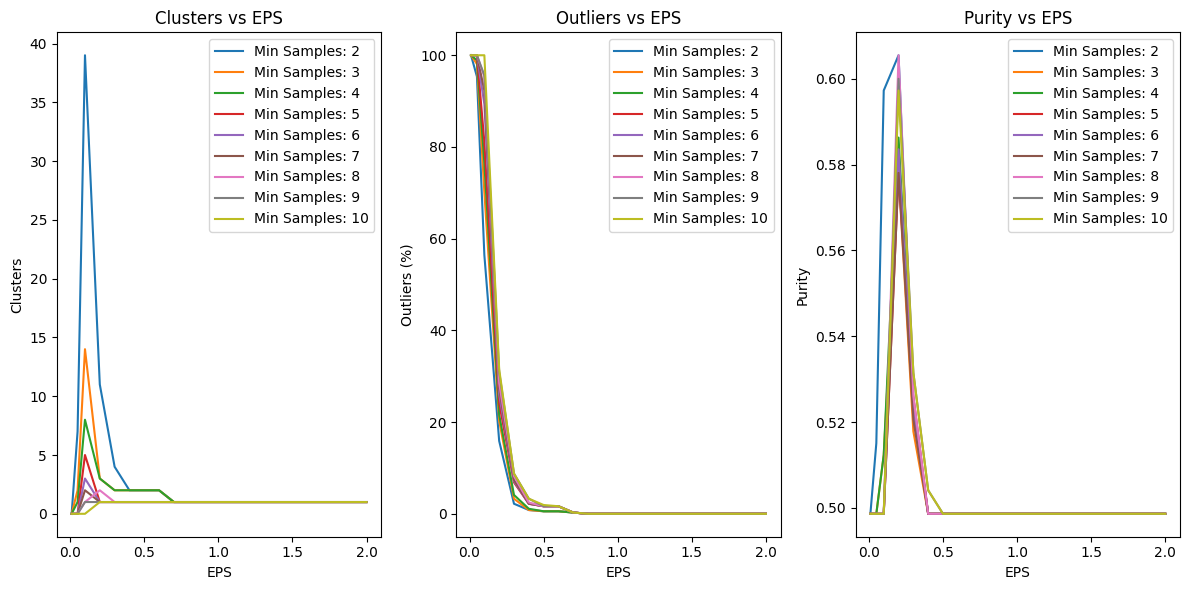

In [33]:
# Map string labels to numerical labels for DBSCAN
label_mapping_d = {label: i for i, label in enumerate(hwd_df['Class'].unique())}
numerical_labels_d = hwd_df['Class'].map(label_mapping_d)


## Expanded EPS and min_samples ranges
eps_values = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.5, 2.0]
min_samples_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]


best_purity_d = 0
best_outliers_d = 1
best_eps = None
best_min_samples = None


## Iterate over EPS and min_samples values
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(hwd_normalized)
        
        # Calculate purity
        dbscan_purity_result = purity(dbscan.labels_, numerical_labels_d, outliers=False)  
        
        # Check number of clusters and outliers
        clusters = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
        outliers = sum(1 for label in dbscan.labels_ if label == -1) / len(dbscan.labels_)
        
        print(f"EPS: {eps}, Min Samples: {min_samples}, Clusters: {clusters}, Outliers: {outliers*100:.2f}%")
        
        if clusters >= 2 and clusters <= 15 and outliers < 0.2 and dbscan_purity_result > best_purity_d:
            best_purity_d = dbscan_purity_result
            best_outliers_d = outliers
            best_eps = eps
            best_min_samples = min_samples


# Print best results
print("\nBest EPS:", best_eps)
print("Best Min Samples:", best_min_samples)
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan.fit(hwd_normalized)
best_clusters = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
print(f"Purity Percentage: {purity(dbscan.labels_, numerical_labels_d, outliers=False)*100:.2f}%")
print(f"Outliers Percentage {sum(1 for label in dbscan.labels_ if label == -1) / len(dbscan.labels_)*100:.2f}%")
print(f"Number of Clusters: {best_clusters}")


# Plot results
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
for min_samples in min_samples_values:
    clusters_list = [len(set(DBSCAN(eps=eps, min_samples=min_samples).fit(hwd_normalized).labels_)) - (1 if -1 in DBSCAN(eps=eps, min_samples=min_samples).fit(hwd_normalized).labels_ else 0) for eps in eps_values]
    plt.plot(eps_values, clusters_list, label=f'Min Samples: {min_samples}')

plt.title('Clusters vs EPS')
plt.xlabel('EPS')
plt.ylabel('Clusters')
plt.legend()

plt.subplot(1, 3, 2)
for min_samples in min_samples_values:
    outliers_list = [sum(1 for label in DBSCAN(eps=eps, min_samples=min_samples).fit(hwd_normalized).labels_ if label == -1) / len(DBSCAN(eps=eps, min_samples=min_samples).fit(hwd_normalized).labels_) * 100 for eps in eps_values]
    plt.plot(eps_values, outliers_list, label=f'Min Samples: {min_samples}')

plt.title('Outliers vs EPS')
plt.xlabel('EPS')
plt.ylabel('Outliers (%)')
plt.legend()

plt.subplot(1, 3, 3)
for min_samples in min_samples_values:
    purity_list = [purity(DBSCAN(eps=eps, min_samples=min_samples).fit(hwd_normalized).labels_, numerical_labels_d, outliers=False) for eps in eps_values]
    plt.plot(eps_values, purity_list, label=f'Min Samples: {min_samples}')

plt.title('Purity vs EPS')
plt.xlabel('EPS')
plt.ylabel('Purity')
plt.legend()

plt.tight_layout()
plt.show()

From the plots above, when EPS is low (0.01-0.1), there are very few clusters identified and a high percentage of outliers (95%+). As EPS increases (0.2-0.3), the number of clusters increases, and the outlier percentage reduces significantly. Further increase in EPS (above 0.3) leads to a stable number of clusters (around 2) but a very low outlier percentage (less than 5%).lower eps values resulted in very few clusters and high outlier rates. Essentially, as eps increased, the number of clusters formed increased, and the outlier percentage decreased. Higher eps values however led to a stable but small number of clusters with very few outliers."

After running the DBSCAN clustering on the Houston Weather Dataset (HWD), the results showed some notable differences compared to the K-means clustering from subtask e. The best DBSCAN clustering was achieved with an epsilon (eps) value of 0.2 and a minimum samples value of 2, resulting in a purity score of 60.55%, 15.89% outliers and 11 clusters. In contrast, the K-means clustering (k=3, run 10 times) produced a higher purity score of 71% (0.705) but had a higher outlier score of 27% (0.27).

Comparing the two methods, DBSCAN's ability to handle noise and outliers more effectively is evident. Although the purity score for DBSCAN was slightly lower, it was able to identify clusters with fewer outliers compared to K-means, which is better at grouping points but struggles with noise. This demonstrates DBSCAN’s strength in separating the "core" clusters from the noise and making it a useful tool in situations where outliers need to be accounted for in the clustering process.



The plot above illustrates the impact of varying EPS values on the number of outliers detected using DBSCAN clustering. As EPS increases, the number of outliers decreases, indicating that a larger neighborhood radius leads to fewer data points being classified as outliers.

## Task 7

EPS: 0.1, Min Samples: 2, Clusters: 32, Outliers: 0.76%
EPS: 0.1, Min Samples: 3, Clusters: 24, Outliers: 1.07%
EPS: 0.1, Min Samples: 4, Clusters: 19, Outliers: 1.39%
EPS: 0.1, Min Samples: 5, Clusters: 18, Outliers: 1.55%
EPS: 0.1, Min Samples: 6, Clusters: 17, Outliers: 1.83%
EPS: 0.1, Min Samples: 7, Clusters: 17, Outliers: 1.95%
EPS: 0.1, Min Samples: 8, Clusters: 19, Outliers: 2.17%
EPS: 0.1, Min Samples: 9, Clusters: 19, Outliers: 2.33%
EPS: 0.1, Min Samples: 10, Clusters: 19, Outliers: 2.63%
EPS: 0.1, Min Samples: 11, Clusters: 18, Outliers: 3.01%
EPS: 0.1, Min Samples: 12, Clusters: 18, Outliers: 3.05%
EPS: 0.1, Min Samples: 13, Clusters: 17, Outliers: 3.30%
EPS: 0.1, Min Samples: 14, Clusters: 16, Outliers: 3.66%
EPS: 0.2, Min Samples: 2, Clusters: 17, Outliers: 0.31%
EPS: 0.2, Min Samples: 3, Clusters: 10, Outliers: 0.57%
EPS: 0.2, Min Samples: 4, Clusters: 10, Outliers: 0.57%
EPS: 0.2, Min Samples: 5, Clusters: 9, Outliers: 0.65%
EPS: 0.2, Min Samples: 6, Clusters: 9, Outli

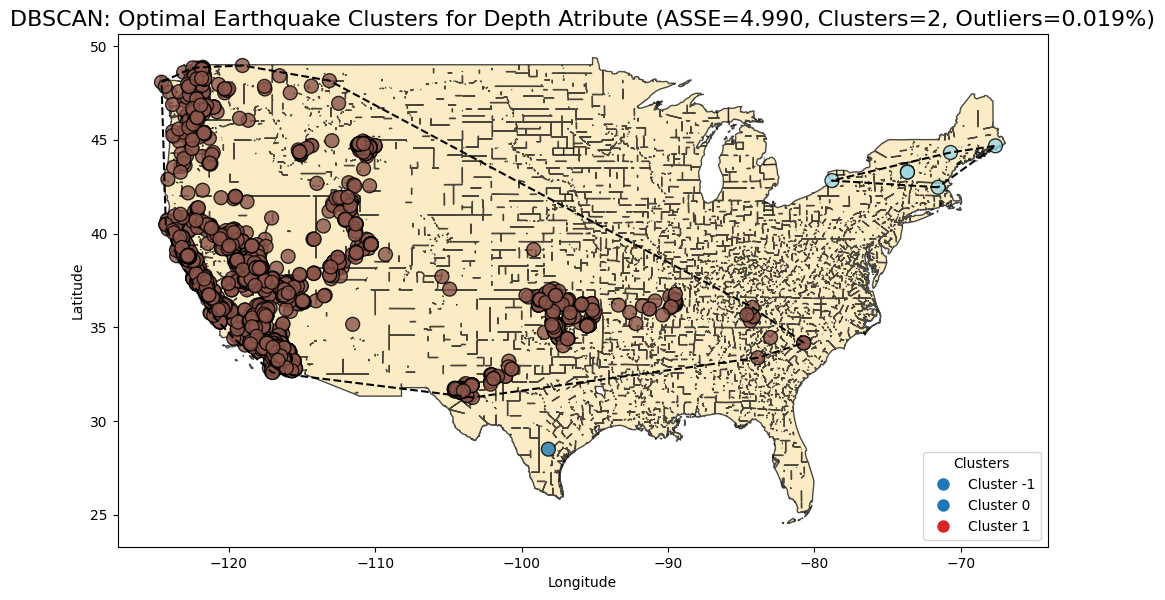

In [66]:
# Define search range for eps and minPts
eps_values = np.arange(0.1, 3.0, 0.1)
minPts_values = np.arange(2, 15, 1)

# Initialize variables for tracking the best configuration
best_eps = None
best_min_samples = None
best_asse = np.inf
best_clusters = None
best_labels = None
best_outliers = None

# Search procedure: Iterate over EPS and min_samples values
for eps in eps_values:
    for min_samples in minPts_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(earthquake_normalized)
        
        # Extract clusters and calculate outlier percentage
        labels = dbscan.labels_
        clusters = len(set(labels)) - (1 if -1 in labels else 0)
        outliers = np.sum(labels == -1) / len(labels)
        
        print(f"EPS: {eps}, Min Samples: {min_samples}, Clusters: {clusters}, Outliers: {outliers*100:.2f}%")
        
        # Filter configurations meeting the constraints
        if clusters >= 2 and clusters <= 15 and outliers < 0.2:
            # Calculate ASSE for the current configuration
            avg_asse = asse(labels, earthquake_df['depth'])
            
            # Update the best configuration if a lower ASSE is found
            if avg_asse < best_asse:
                best_eps = eps
                best_min_samples = min_samples
                best_asse = avg_asse
                best_clusters = clusters
                best_labels = labels
                best_outliers = outliers * 100

# Run DBSCAN with the best parameters found
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan.fit(earthquake_normalized)
earthquake_df['cluster'] = dbscan.labels_

# Calculate ASSE for each cluster
cluster_asse_values = []
for cluster in np.unique(best_labels):
    if cluster == -1:  # Skip outliers
        continue
    cluster_mask = (best_labels == cluster)
    cluster_depths = earthquake_df['depth'][cluster_mask]
    cluster_mean = np.mean(cluster_depths)
    squared_errors = np.sum((cluster_depths - cluster_mean) ** 2)
    cluster_asse = squared_errors / len(cluster_depths)
    cluster_asse_values.append(cluster_asse)

average_asse = np.mean(cluster_asse_values)

# Print best results
print("\nBest DBSCAN Results:")
print("Best EPS:", best_eps)
print("Best Min Samples:", best_min_samples)
print("Best Clusters:", best_clusters)
print("Outliers Percentage:", best_outliers)
print("ASSE for Depth:", best_asse)
print("Average ASSE:", average_asse)
print("ASSE values for each cluster:", cluster_asse_values)

# Visualization of the clusters
visualize_eq_clusters_with_boundaries(earthquake_df.assign(cluster=lambda x: dbscan.labels_),
                      "longitudes", "latitudes", "cluster",
                      title=f"DBSCAN: Optimal Earthquake Clusters for Depth Atribute (ASSE={best_asse:.3f}, Clusters={best_clusters}, Outliers={best_outliers:.3f}%)",
                      asse_score=best_asse)

After running DBSCAN clustering on the Earthquake dataset, the search for optimal parameters involved varying the epsilon (eps) and minimum samples values to find the best clustering result with DBSCAN. The goal was to optimize DBSCAN parameters—epsilon (\(\epsilon\)) and minimum points (\(minPts\))—to achieve meaningful clusters while minimizing the Average Sum of Squared Errors (ASSE) for the earthquake depth attribute. After a systematic search, the best configuration was found with \(\epsilon = 0.8\) and \(minPts = 2\), resulting in **two clusters** and an overall ASSE score of **4.990** for depth. Additionally, the average ASSE for the clusters was **14.722**, with one cluster showing a much higher ASSE value (Cluster 0: **23.621**) compared to the other (Cluster 1: **5.822**). 

This result stands out when compared to the K-means clustering results obtained in subtask d. K-means produced **13 clusters** at \(k = 13\), yielding an ASSE score of **17.180** for the depth attribute. While K-means identified more clusters, its higher ASSE value reflects its limitations in handling the variability and noise present in the dataset. In contrast, DBSCAN’s ability to detect non-linear cluster boundaries and exclude noise resulted in a more compact and meaningful clustering structure, evidenced by its significantly lower ASSE score. The comparison clearly shows that DBSCAN is better suited for datasets with irregular distributions and outliers, such as this earthquake data, focusing on the depth attribute.

#### Description of the search procedure
The search procedure for DBSCAN parameters involved exploring a range of values for \(\epsilon\) (from 0.1 to 3.0 in steps of 0.1) and \(minPts\) (from 2 to 15). Each combination of parameters was tested against constraints requiring 2 to 15 clusters and an outlier percentage below 20%. For configurations meeting these constraints, the ASSE score for depth was calculated. The configuration with the lowest ASSE score was selected as the best. This systematic approach ensured the parameters were optimized not only for minimizing error but also for maintaining a balance between cluster quality and noise handling. The outliers (Cluster -1) represent the sparse regions of the data that DBSCAN effectively excludes, in this case that was 1 data point..

DBSCAN’s clustering map showed the two clusters identified which represent distinct spatial patterns of earthquake activity-DBSCAN did well in separating dense regions from noise. On the other hand, K-means produced more clusters, but its inability to distinguish outliers meant those sparse data points were incorrectly assigned to clusters.

Overall, DBSCAN outperformed K-means in terms of clustering quality for the earthquake depth attribute. Its ability to handle noise and irregular data distributions made it a more effective choice for this dataset. While K-means is a reliable algorithm for uniformly distributed data, DBSCAN’s adaptability and robustness in excluding outliers made it the superior choice for this data. 

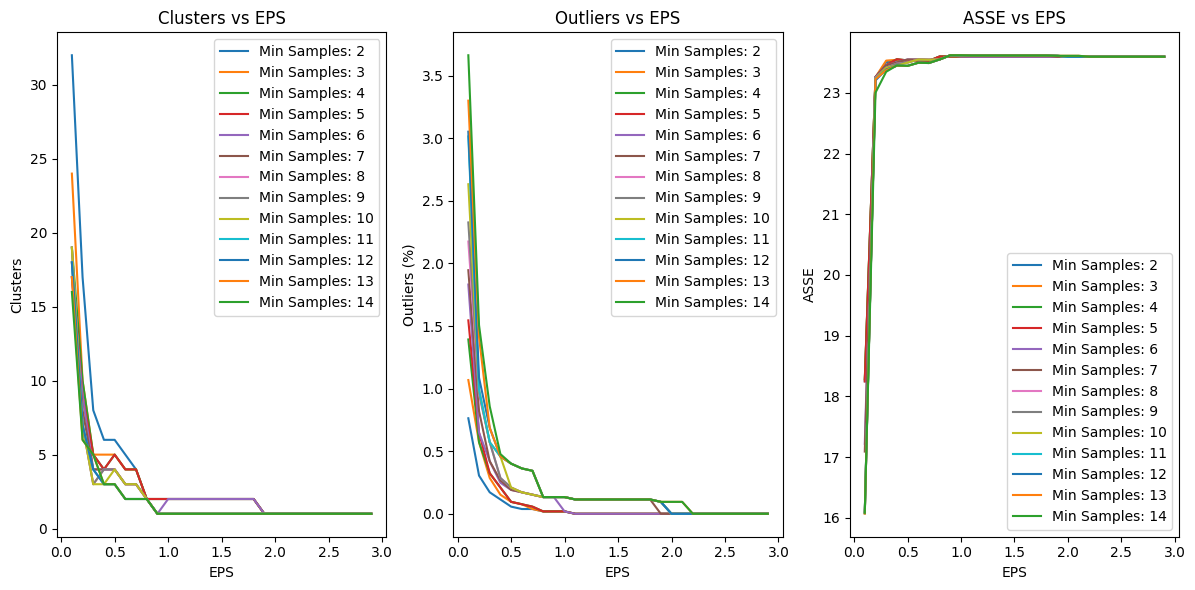

In [79]:
# Plot results
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
for min_samples in minPts_values:
    clusters_list = [len(set(DBSCAN(eps=eps, min_samples=min_samples).fit(earthquake_normalized).labels_)) - (1 if -1 in DBSCAN(eps=eps, min_samples=min_samples).fit(earthquake_normalized).labels_ else 0) for eps in eps_values]
    plt.plot(eps_values, clusters_list, label=f'Min Samples: {min_samples}')

plt.title('Clusters vs EPS')
plt.xlabel('EPS')
plt.ylabel('Clusters')
plt.legend()

plt.subplot(1, 3, 2)
for min_samples in minPts_values:
    outliers_list = [sum(1 for label in DBSCAN(eps=eps, min_samples=min_samples).fit(earthquake_normalized).labels_ if label == -1) / len(DBSCAN(eps=eps, min_samples=min_samples).fit(earthquake_normalized).labels_) * 100 for eps in eps_values]
    plt.plot(eps_values, outliers_list, label=f'Min Samples: {min_samples}')

plt.title('Outliers vs EPS')
plt.xlabel('EPS')
plt.ylabel('Outliers (%)')
plt.legend()

plt.subplot(1, 3, 3)
for min_samples in minPts_values:
    asse_list = []
    for eps in eps_values:
        labels = DBSCAN(eps=eps, min_samples=min_samples).fit(earthquake_normalized).labels_
        cluster_values = {}
        for label in set(labels):
            if label != -1:
                cluster_values[label] = earthquake_df['depth'][labels == label]
        
        total_squared_error = 0
        total_examples = 0
        for cluster, values in cluster_values.items():
            cluster_mean = np.mean(values)
            squared_errors = np.sum((values - cluster_mean) ** 2)
            total_squared_error += squared_errors
            total_examples += len(values)
        
        if total_examples > 0:
            asse_list.append(total_squared_error / total_examples)
        else:
            asse_list.append(0)
    
    plt.plot(eps_values, asse_list, label=f'Min Samples: {min_samples}')

plt.title('ASSE vs EPS')
plt.xlabel('EPS')
plt.ylabel('ASSE')
plt.legend()

plt.tight_layout()
plt.show()


**Clusters vs EPS:**

* As EPS increases, the number of clusters generally decreases. This is because a larger EPS value allows points to be considered neighbors even if they are farther apart.
* The number of clusters also depends on the minimum samples parameter. A higher minimum samples value requires more points to form a cluster, leading to fewer clusters.

**Outliers vs EPS:**

* As EPS increases, the number of outliers decreases. This is because a larger EPS value makes it easier for points to be included in clusters, reducing the number of points that are considered outliers.
* The minimum samples parameter also affects the number of outliers. A higher minimum samples value can lead to more outliers as it becomes harder to form clusters.

**ASSE vs EPS:**

* Lower ASSE values indicate better clustering performance.
* The optimal EPS value using DBSCAN () minimizing ASSE was 0.8.
* Increasing EPS beyond this range didn't significantly improve the ASSE

**In Conclusion:**

The plots indicate that a balance needs to be struck between the number of clusters, the percentage of outliers, and the ASSE value. A higher EPS value can reduce the number of outliers and improve clustering quality, but it can also lead to fewer clusters. The minimum samples parameter also helps to fine-tune the clustering process and achieve the desired balance between these constraints.


